# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [1]:
# Warning Supression
import warnings
from pandas.errors import PerformanceWarning 

warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=PerformanceWarning)

# Suppress warnings from yfinance
warnings.filterwarnings("ignore", category=UserWarning, module='yfinance')

# Suppress specific warnings from yfinance
warnings.filterwarnings("ignore", message=".*no price data found.*")


In [2]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)


# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(1000)                                                                        

# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()


,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


remove all stocks except common stocks

In [3]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


below are the 10 technical indicators we are going to use for this project.
1. Relative Strength Index (RSI)
2. Moving Average Convergence Divergence (MACD)
3. Stochastic Oscillator
4. Simple Moving Average (SMA)
5. Exponential Moving Average (EMA)
6. Volume Weighted Average Price (VWAP)
7. Bollinger Bands
8. Average True Range (ATR)
9. Fibonacci Retracement 

In [4]:
# Remove stock tickers not found on yahoo finance
import yfinance as yf
import pandas as pd

# Convert df_filtered['Symbol'] to a list
stock_list = df_filtered['Symbol'].head(50).astype(str).tolist()

# Function to check if a stock ticker is valid
def is_valid_ticker(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="1d")  # Fetch 1 day of historical data
        return not hist.empty  # Valid if data is not empty
    except Exception as e:
        return False  # If there's an error, consider it invalid

# Filter out invalid tickers
valid_tickers = [ticker for ticker in stock_list if is_valid_ticker(ticker)]

# Keep only valid tickers in df_filtered
df_filtered = df_filtered[df_filtered['Symbol'].isin(valid_tickers)]

# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1


Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)
$BRK/A: possibly delisted; no price data found  (period=1d)
Failed to get ticker 'BRK/B' reason: Expecting value: line 1 column 1 (char 0)
$BRK/B: possibly delisted; no price data found  (period=1d)


In [5]:
# Keep this one, this is how i got the yahoo data, easier and works faster

import yfinance as yf
import pandas as pd

# Convert df_filtered['Symbol'] to a list of top 25 stocks by marketcap
stock_list = df_filtered['Symbol'].head(25).astype(str).tolist()

# Download data for all stocks
data = yf.download(stock_list, start="2015-01-01", end="2025-02-27", auto_adjust=True, actions=False)[['Close', 'Open', 'High', 'Low', 'Volume']]

# Reshape the data: Convert tickers from columns to rows
daily_stock_price = data.stack().reset_index()

# Rename columns for clarity
daily_stock_price.columns = ['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume']

# Display the transformed DataFrame
daily_stock_price.head()


[*********************100%***********************]  25 of 25 completed


,Date,Symbol,Close,Open,Daily_High,Daily_Low,Volume
0,2015-01-02,AAPL,24.320431,24.778677,24.789800,23.879980,212818400
1,2015-01-02,ABBV,43.156208,42.861472,43.490246,42.861472,5086100
2,2015-01-02,AMZN,15.426000,15.629000,15.737500,15.348000,55664000
3,2015-01-02,AVGO,7.628655,7.692679,7.790237,7.555486,13500000
4,2015-01-02,BAC,14.532613,14.605682,14.638158,14.354000,48951100


In [6]:
# Now group by 'Symbol' and reset the index for the entire dataframe
daily_stock_price = daily_stock_price.groupby('Symbol').apply(lambda x: x.reset_index(drop=True))

# Fill down the 'Symbol' column (so it repeats for each stock's data)
daily_stock_price['Symbol'] = daily_stock_price['Symbol'].fillna(method='ffill')

# Reset the index again and drop the existing 'Symbol' index
daily_stock_price = daily_stock_price.reset_index(drop=True)

# Display the first few rows
daily_stock_price.head()


,Date,Symbol,Close,Open,Daily_High,Daily_Low,Volume
0,2015-01-02,AAPL,24.320431,24.778677,24.789800,23.879980,212818400
1,2015-01-05,AAPL,23.635283,24.089080,24.169162,23.448426,257142000
2,2015-01-06,AAPL,23.637512,23.699798,23.897778,23.274918,263188400
3,2015-01-07,AAPL,23.968960,23.846612,24.069062,23.735387,160423600
4,2015-01-08,AAPL,24.889902,24.298187,24.947740,24.180287,237458000


In [1181]:
# Make sure Date column is in datetime datatype format
daily_stock_price['Date'] = pd.to_datetime(daily_stock_price['Date'], errors='coerce')


In [1182]:
stock_data_1_week = daily_stock_price.copy()
one_week_window = [5, 3, 7]

In [1183]:
# Daily Volume MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Volume_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Volume'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

# Daily High Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Daily_High_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Daily_High'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )   

# Daily Low Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Daily_Low_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Daily_Low'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )   

# Daily Open Price MA
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'Open_{window}day_avg'] = stock_data_1_week.groupby('Symbol')['Open'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )


In [1184]:
# adust top features before dropping
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg'],
      dtype='object')

In [1185]:
# Exponential Moving Average

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'EMA_{window}'] = stock_data_1_week.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).ewm(span=window, adjust=False).mean()
        )
       


In [1186]:
# Simple Moving Average

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'SMA_{window}'] = stock_data_1_week.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )


In [1187]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7'],
      dtype='object')

In [1188]:
# RSI

# Define a function to calculate RSI
def calculate_rsi(stock_data_1_week, window):
    # Calculate price changes
    delta = stock_data_1_week['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    stock_data_1_week['RSI'] = rsi

    return rsi.shift(-1)

calculate_rsi(stock_data_1_week, 14)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'RSI_{window}'] = stock_data_1_week.groupby('Symbol', group_keys=False).apply(
        lambda x: calculate_rsi(x, window=window)
        ).reset_index(drop=True)
        if window == 14:
            stock_data_1_week.drop(columns = ['RSI_14'], inplace=True)
        else:
            continue


In [1189]:
# MACD

def calculate_macd(df):
    
    df['EMA_12_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=12, adjust=False).mean()
    )
    df['EMA_26_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=26, adjust=False).mean()
    )

    df['MACD'] = df['EMA_12_MACD'] - df['EMA_26_MACD']
    df['Signal_Line'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.ewm(span=9, adjust=False).mean()
    )
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    df.drop(columns = ['EMA_12_MACD', 'EMA_26_MACD'], inplace=True)

  

def calculate_rolling_macd(df, window):
    # Apply rolling average to the MACD, Signal Line, and MACD Histogram with a shift to avoid future data leakage
    df[f'MACD_rolling_{window}'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
    df[f'Signal_rolling_{window}'] = df.groupby('Symbol')['Signal_Line'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
    df[f'MACD_Histogram_rolling_{window}'] = df.groupby('Symbol')['MACD_Histogram'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    
  

calculate_macd(stock_data_1_week)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        calculate_rolling_macd(stock_data_1_week, window)







In [1190]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7'],
      dtype='object')

In [1191]:
# stochastic oscillator
def calculate_stoch_oscillator(df, windows):
        
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    df[f'%K_{window}'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df[f'%D_{window}'] = df.groupby('Symbol')[f'%K_{window}'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean().shift(1)
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)

 
    

def standard_stoch_oscillator(df):
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=14, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=14, min_periods=1).max()
    )
    
    df['%K'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df['%D'] = df.groupby('Symbol')['%K'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)
  


standard_stoch_oscillator(stock_data_1_week)

for col in stock_data_1_week.columns:  
    for window in one_week_window:
        calculate_stoch_oscillator(stock_data_1_week, window)

    


In [1192]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Calculate cumulative price-volume product for VWAP
    df['Cumulative_Price_Volume'] = df.groupby('Symbol')['Close'].transform(
    lambda x: (x * df.loc[x.index, 'Volume']).cumsum()
    )
    # Calculate cumulative volume for VWAP
    df['Cumulative_Volume'] = df.groupby('Symbol')['Volume'].transform(
    lambda x: x.cumsum()
    )
    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']



# Add VWAP and VWAP window averages to dataframes
    
calculate_vwap(stock_data_1_week)
for col in stock_data_1_week.columns:

    for window in one_week_window:

        stock_data_1_week[f'VWAP_{window}'] = stock_data_1_week.groupby('Symbol')['VWAP'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

        

stock_data_1_week.drop(columns=['Cumulative_Price_Volume', 'Cumulative_Volume'], inplace=True)
    

In [1193]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7', '%K', '%D', '%K_5',
       '%D_5', '%K_3', '%D_3', '%K_7', '%D_7', 'VWAP', 'VWAP_5', 'VWAP_3',
       'VWAP_7'],
      dtype='object')

In [1194]:
# Calculate Bollinger Bands per symbol

def calculate_bollinger_bands(df):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    df['Middle_Band'] = df.groupby('Symbol')['Close'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
    )
    
    df['Std_Dev'] = df.groupby('Symbol')['Close'].transform(
    lambda x: x.rolling(window=window, min_periods=1).std().shift(1)
    )
    
    df['Upper_Band'] = df['Middle_Band'] + (df['Std_Dev'] * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Std_Dev'] * 2)



def calculate_bollinger_band_windows(df, windows):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    for window in windows:
        df[f'Middle_Band_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

        df[f'Std_Dev_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std().shift(1)
        )

        df[f'Upper_Band_{window}'] = df[f'Middle_Band_{window}'] + (df[f'Std_Dev_{window}'] * 2)
        df[f'Lower_Band_{window}'] = df[f'Middle_Band_{window}'] - (df[f'Std_Dev_{window}'] * 2)
   


# Add Bollinger Bands to all dataframes

calculate_bollinger_bands(stock_data_1_week)   
for col in stock_data_1_week.columns:
    calculate_bollinger_band_windows(stock_data_1_week, one_week_window)
            


In [1195]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Daily_High'] = pd.to_numeric(df['Daily_High'], errors='coerce')
    df['Daily_Low'] = pd.to_numeric(df['Daily_Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['Daily_High'] - df['Daily_Low']  # High - Low
    df['ATR_High_Close'] = (df['Daily_High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Daily_Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    df.drop(columns=['ATR_Prev_Close', 'ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close'], inplace=True)
    


calculate_true_range(stock_data_1_week)

# Add ATR calculation to all dataframes and add rolling windows
for col in stock_data_1_week.columns:
    for window in one_week_window:
        stock_data_1_week[f'ATR_{window}'] = stock_data_1_week.groupby('Symbol')['ATR'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )

In [1196]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       'Daily_High_5day_avg', 'Daily_High_3day_avg', 'Daily_High_7day_avg',
       'Daily_Low_5day_avg', 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
       'Open_5day_avg', 'Open_3day_avg', 'Open_7day_avg', 'EMA_5', 'EMA_3',
       'EMA_7', 'SMA_5', 'SMA_3', 'SMA_7', 'RSI', 'RSI_5', 'RSI_3', 'RSI_7',
       'MACD', 'Signal_Line', 'MACD_Histogram', 'MACD_rolling_5',
       'Signal_rolling_5', 'MACD_Histogram_rolling_5', 'MACD_rolling_3',
       'Signal_rolling_3', 'MACD_Histogram_rolling_3', 'MACD_rolling_7',
       'Signal_rolling_7', 'MACD_Histogram_rolling_7', '%K', '%D', '%K_5',
       '%D_5', '%K_3', '%D_3', '%K_7', '%D_7', 'VWAP', 'VWAP_5', 'VWAP_3',
       'VWAP_7', 'Middle_Band', 'Std_Dev', 'Upper_Band', 'Lower_Band',
       'Middle_Band_5', 'Std_Dev_5', 'Upper_Band_5', 'Lower_Band_5',
       'Middle_Band_3', 'Std_Dev_3', 'Upper_Band_3', 

In [1197]:
import numpy as np
import pandas as pd

# Group by 'Symbol' and calculate Fibonacci levels for a given window
def fib_retracement(df, windows, levels):
    for window in windows:
        # Calculate rolling max and min for each window
        df[f'Fib_{window}_High_Max'] = df.groupby('Symbol')['Daily_High'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
        )
        df[f'Fib_{window}_Low_Min'] = df.groupby('Symbol')['Daily_Low'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
        )
    
        # Calculate Fibonacci retracement levels for each level
        for level in fib_levels:
            df[f'{window}_day_Fib_{level*100:.1f}%'] = df[f'Fib_{window}_High_Max'] - (
                level * (df[f'Fib_{window}_High_Max'] - df[f'Fib_{window}_Low_Min']))
        df.drop(columns = [f'Fib_{window}_High_Max', f'Fib_{window}_Low_Min'], inplace=True)
    



# Define Fibonacci levels
fib_levels = [0.236, 0.382, 0.500, 0.618, 0.786, 1.000, 1.618, 2.618, 4.236]
# fib_windows = [5, 14, 30]

fib_retracement(stock_data_1_week, one_week_window, fib_levels)


In [1198]:
# OBV

def calculate_obv(df):
    df['OBV'] = df.groupby('Symbol').apply(
        lambda group: (np.sign(group['Close'].diff()) * group['Volume']).cumsum()
    ).reset_index(level=0, drop=True)

    df['OBV'] = df['OBV'].shift(1)
    
    df['OBV'] = df['OBV'].fillna(0) 

    return df

def calculate_rolling_obv(df, windows):
    df[f'OBV_{window}day_avg'] = df.groupby('Symbol')['OBV'].transform(
        lambda x: x.rolling(window=window).mean()
    )

    df[f'OBV_{window}day_avg'] = df[f'OBV_{window}day_avg'].fillna(0)
    


calculate_obv(stock_data_1_week)

for col in stock_data_1_week.columns:
    for window in one_week_window:
        calculate_rolling_obv(stock_data_1_week, window)


In [1199]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       ...
       '7_day_Fib_61.8%', '7_day_Fib_78.6%', '7_day_Fib_100.0%',
       '7_day_Fib_161.8%', '7_day_Fib_261.8%', '7_day_Fib_423.6%', 'OBV',
       'OBV_5day_avg', 'OBV_3day_avg', 'OBV_7day_avg'],
      dtype='object', length=104)

In [1200]:
# Momentum Features

def calculate_momentum(df, windows):
    for window in windows:

        df[f'Momentum_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x - x.shift(window)
        ).fillna(0)


calculate_momentum(stock_data_1_week, one_week_window)



In [1201]:
# Quantile-Based Features

def calculate_quantiles(df, windows):

    for window in windows:
    
        df[f'Rolling_Median_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).median()
        ).fillna(0)
    
        # Rolling 25th Quantile
        df[f'Rolling_Quantile_25_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).quantile(0.25)
        ).fillna(0)
    
        # Rolling 75th Quantile
        df[f'Rolling_Quantile_75_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.shift(1).rolling(window=window).quantile(0.75)
        ).fillna(0)


calculate_quantiles(stock_data_1_week, one_week_window)


In [1202]:
stock_data_1_week.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Daily_High', 'Daily_Low', 'Volume',
       'Volume_5day_avg', 'Volume_3day_avg', 'Volume_7day_avg',
       ...
       'Momentum_7', 'Rolling_Median_5', 'Rolling_Quantile_25_5',
       'Rolling_Quantile_75_5', 'Rolling_Median_3', 'Rolling_Quantile_25_3',
       'Rolling_Quantile_75_3', 'Rolling_Median_7', 'Rolling_Quantile_25_7',
       'Rolling_Quantile_75_7'],
      dtype='object', length=116)

In [1203]:

# and using that instead, may change it to top 30 if we see noticible improvement
# Running baseline model in order to keep track feature importance 
# as we continue to add more features
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb


# Initialize dictionary to keep track of feature importance as we add more features
# After adding our final features, we will remove any features that have less than 
# a 1% feature importance total

stock_data_important_feat = stock_data_1_week.copy()

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_important_feat = stock_data_important_feat.sort_values(by=['Symbol', 'Date'])

# Train on all data before 2023-01-24, test all data after 2023-01-31
stock_data_train = stock_data_important_feat[stock_data_important_feat['Date'] <= '2023-01-24']
stock_data_test = stock_data_important_feat[stock_data_important_feat['Date'] > '2023-01-31']

# Check if the test set is empty
#if stock_data_test.empty:
    #raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train['Close_Target'] = stock_data_train.groupby('Symbol')['Close'].shift(-5)
stock_data_test['Close_Target'] = stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train = stock_data_train.dropna(subset=['Close_Target'])
stock_data_test = stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test.select_dtypes(include=[np.number]).columns

stock_data_train[numeric_cols_train] = stock_data_train[numeric_cols_train].fillna(stock_data_train[numeric_cols_train].median())
stock_data_test[numeric_cols_test] = stock_data_test[numeric_cols_test].fillna(stock_data_test[numeric_cols_test].median())

# Create X (features) and y (target) for training
X_train = stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = stock_data_train['Close_Target']

# Create X and y for testing
X_test = stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = stock_data_test['Close_Target']

# Ensure there are samples in both training and testing sets
# if X_train.shape[0] == 0 or X_test.shape[0] == 0:
#     raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan, # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions 
y_pred_ = model.predict(X_test)

# not doinng this anymore, instead we are getting list of top 20 important features
# and using that instead, may change it to top 30 if we see noticible improvement

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort by importance and select top 10
top_50_important_features = feature_importance.nlargest(50).index.tolist()
print("Top 50 Important Features:", top_50_important_features)


Top 50 Important Features: ['Daily_Low', 'Daily_High', '3_day_Fib_50.0%', '5_day_Fib_50.0%', 'Rolling_Quantile_25_3', '5_day_Fib_100.0%', '3_day_Fib_78.6%', '5_day_Fib_23.6%', 'EMA_5', 'EMA_7', '7_day_Fib_78.6%', 'Rolling_Quantile_25_7', 'SMA_5', '7_day_Fib_23.6%', 'Upper_Band', 'Rolling_Median_7', 'Open_5day_avg', 'Rolling_Quantile_75_5', 'Rolling_Quantile_25_5', '7_day_Fib_38.2%', 'Open_7day_avg', 'Rolling_Quantile_75_3', 'Rolling_Quantile_75_7', '7_day_Fib_61.8%', 'Daily_Low_3day_avg', 'Daily_High_7day_avg', 'Daily_High_5day_avg', 'Lower_Band_3', 'Rolling_Median_5', 'Lower_Band_5', 'SMA_7', 'Upper_Band_5', '3_day_Fib_261.8%', '3_day_Fib_161.8%', 'Open', 'Upper_Band_3', '3_day_Fib_61.8%', '7_day_Fib_100.0%', '7_day_Fib_261.8%', '7_day_Fib_161.8%', 'Daily_Low_7day_avg', 'Open_3day_avg', 'VWAP_3', '5_day_Fib_261.8%', '5_day_Fib_161.8%', 'VWAP_7', 'Daily_Low_5day_avg', '3_day_Fib_23.6%', 'EMA_3', 'VWAP']


In [1204]:
stock_data_1_week.shape

(63825, 116)

In [1205]:
# List of columns to create lags for (focusing on short-term indicators)
# features_to_lag = top_features[2:23]

# exclude_columns = ['Symbol', 'Date', 'Close']
# columns_to_lag = [col for col in stock_data_1_week.columns if col not in exclude_columns]
# features_to_lag = columns_to_lag
features_to_lag = top_50_important_features[:20]

# Creating lag features for each column
lags = [1, 2, 3, 4, 5]

def calculate_lag(df, features, lags):
    # Apply lags to the dataframe
    for col in features:
        if col in df.columns:
            for lag in lags:
                if f'{col}_lag_{lag}' not in df.columns:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            # else:
                # print(f"Column '{col}' not found in dataframe, skipping.")


# Assuming stock_dataframes is a list of your dataframes

calculate_lag(stock_data_1_week, features_to_lag, lags)
    
stock_data_1_week.shape

(63825, 216)

In [1206]:

# and using that instead, may change it to top 30 if we see noticible improvement
# Running baseline model in order to keep track feature importance 
# as we continue to add more features
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import xgboost as xgb


# Initialize dictionary to keep track of feature importance as we add more features
# After adding our final features, we will remove any features that have less than 
# a 1% feature importance total

stock_data_important_feat = stock_data_1_week.copy()

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_important_feat = stock_data_important_feat.sort_values(by=['Symbol', 'Date'])

# Train on all data before 2023-01-24, test all data after 2023-01-31
stock_data_train = stock_data_important_feat[stock_data_important_feat['Date'] <= '2023-01-24']
stock_data_test = stock_data_important_feat[stock_data_important_feat['Date'] > '2023-01-31']

# Check if the test set is empty
#if stock_data_test.empty:
    #raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train['Close_Target'] = stock_data_train.groupby('Symbol')['Close'].shift(-5)
stock_data_test['Close_Target'] = stock_data_test.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train = stock_data_train.dropna(subset=['Close_Target'])
stock_data_test = stock_data_test.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test.select_dtypes(include=[np.number]).columns

stock_data_train[numeric_cols_train] = stock_data_train[numeric_cols_train].fillna(stock_data_train[numeric_cols_train].median())
stock_data_test[numeric_cols_test] = stock_data_test[numeric_cols_test].fillna(stock_data_test[numeric_cols_test].median())

# Create X (features) and y (target) for training
X_train = stock_data_train.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train = stock_data_train['Close_Target']

# Create X and y for testing
X_test = stock_data_test.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test = stock_data_test['Close_Target']

# Ensure there are samples in both training and testing sets
# if X_train.shape[0] == 0 or X_test.shape[0] == 0:
#     raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan, # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions 
y_pred_ = model.predict(X_test)

# not doinng this anymore, instead we are getting list of top 20 important features
# and using that instead, may change it to top 30 if we see noticible improvement

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort by importance and select top 50
top_50_important_features = feature_importance.nlargest(50).index.tolist()
print("Top 50 Important Features:", top_50_important_features)


Top 50 Important Features: ['Daily_Low', 'SMA_5_lag_5', '3_day_Fib_61.8%', 'Daily_High', '5_day_Fib_50.0%', '3_day_Fib_50.0%', 'Daily_Low_lag_3', '3_day_Fib_78.6%', 'Daily_Low_lag_5', 'Rolling_Quantile_25_7', 'Rolling_Quantile_25_3', 'Upper_Band', '5_day_Fib_100.0%', '5_day_Fib_23.6%', 'Daily_Low_lag_1', '7_day_Fib_23.6%', '3_day_Fib_50.0%_lag_1', 'EMA_5', 'SMA_5', 'Rolling_Quantile_75_5', 'Open_5day_avg', 'Rolling_Quantile_75_3', 'Daily_High_7day_avg', '5_day_Fib_78.6%', '7_day_Fib_38.2%', 'Open_7day_avg', 'Upper_Band_5', 'EMA_7', '7_day_Fib_61.8%', 'Lower_Band_3', 'Rolling_Quantile_25_5', '5_day_Fib_100.0%_lag_4', 'Daily_High_5day_avg', '7_day_Fib_38.2%_lag_2', 'Rolling_Quantile_75_7', '7_day_Fib_23.6%_lag_1', 'SMA_7', 'Rolling_Median_5', 'Lower_Band_5', '7_day_Fib_23.6%_lag_5', 'EMA_5_lag_5', '5_day_Fib_100.0%_lag_5', '3_day_Fib_261.8%', 'Upper_Band_3', '5_day_Fib_23.6%_lag_1', '3_day_Fib_161.8%', '7_day_Fib_100.0%', '7_day_Fib_161.8%', '7_day_Fib_78.6%', '7_day_Fib_261.8%']


In [1208]:
descriptive_features = ['Symbol', 'Date']

target_feature = ['Close']

filtered_features = descriptive_features + target_feature + top_50_important_features

stock_data_1_week = stock_data_1_week[filtered_features]

In [1209]:
stock_data_1_week.shape

(63825, 53)

In [1210]:
# List of columns to create lags for (focusing on short-term indicators)
# features_to_lag = top_features[2:23]


features_to_lag = target_feature

# Creating lag features for each column
lags = [1, 2, 3, 4, 5]

def calculate_lag(df, features, lags):
    # Apply lags to the dataframe
    for col in features:
        if col in df.columns:
            for lag in lags:
                if f'{col}_lag_{lag}' not in df.columns:
                    df[f'{col}_lag_{lag}'] = df[col].shift(lag)
            # else:
                # print(f"Column '{col}' not found in dataframe, skipping.")


# Assuming stock_dataframes is a list of your dataframes

calculate_lag(stock_data_1_week, features_to_lag, lags)
    
stock_data_1_week.head()

,Symbol,Date,Close,Daily_Low,SMA_5_lag_5,3_day_Fib_61.8%,Daily_High,5_day_Fib_50.0%,3_day_Fib_50.0%,Daily_Low_lag_3,3_day_Fib_78.6%,Daily_Low_lag_5,Rolling_Quantile_25_7,Rolling_Quantile_25_3,Upper_Band,5_day_Fib_100.0%,5_day_Fib_23.6%,Daily_Low_lag_1,7_day_Fib_23.6%,3_day_Fib_50.0%_lag_1,EMA_5,SMA_5,Rolling_Quantile_75_5,Open_5day_avg,Rolling_Quantile_75_3,Daily_High_7day_avg,5_day_Fib_78.6%,7_day_Fib_38.2%,Open_7day_avg,Upper_Band_5,EMA_7,7_day_Fib_61.8%,Lower_Band_3,Rolling_Quantile_25_5,5_day_Fib_100.0%_lag_4,Daily_High_5day_avg,7_day_Fib_38.2%_lag_2,Rolling_Quantile_75_7,7_day_Fib_23.6%_lag_1,SMA_7,Rolling_Median_5,Lower_Band_5,7_day_Fib_23.6%_lag_5,EMA_5_lag_5,5_day_Fib_100.0%_lag_5,3_day_Fib_261.8%,Upper_Band_3,5_day_Fib_23.6%_lag_1,3_day_Fib_161.8%,7_day_Fib_100.0%,7_day_Fib_161.8%,7_day_Fib_78.6%,7_day_Fib_261.8%,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
0,AAPL,2015-01-02,24.320431,23.879980,NaN,NaN,24.789800,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2015-01-05,23.635283,23.448426,NaN,24.227531,24.169162,24.334890,24.334890,NaN,24.074681,NaN,0.0,0.000000,NaN,23.879980,24.575082,23.879980,24.575082,NaN,24.320431,24.320431,0.0,24.778677,0.000000,24.789800,24.074681,24.442248,24.778677,NaN,24.320431,24.227531,NaN,0.0,NaN,24.789800,NaN,0.0,NaN,24.320431,0.0,NaN,NaN,NaN,NaN,22.407890,NaN,NaN,23.317711,23.879980,23.317711,24.074681,22.407890,24.320431,NaN,NaN,NaN,NaN
2,AAPL,2015-01-06,23.637512,23.274918,NaN,23.960831,23.897778,24.119113,24.119113,NaN,23.735480,NaN,0.0,0.000000,24.946803,23.448426,24.473236,23.448426,24.473236,24.334890,24.092048,23.977857,0.0,24.433878,0.000000,24.479481,23.735480,24.277395,24.433878,24.946803,24.149144,23.960831,23.008911,0.0,NaN,24.479481,NaN,0.0,24.575082,23.977857,0.0,23.008911,NaN,NaN,NaN,21.278082,24.946803,24.575082,22.619456,23.448426,22.619456,23.735480,21.278082,23.635283,24.320431,NaN,NaN,NaN
3,AAPL,2015-01-07,23.968960,23.735387,NaN,23.853603,24.069062,24.032359,24.032359,23.879980,23.599103,NaN,0.0,23.636397,24.654265,23.274918,24.432288,23.274918,24.432288,24.119113,23.940536,23.864408,0.0,24.189185,23.978971,24.285580,23.599103,24.211115,24.189185,24.654265,24.021236,23.853603,23.074552,0.0,NaN,24.285580,24.442248,0.0,24.473236,23.864408,0.0,23.074552,NaN,NaN,NaN,20.823839,24.654265,24.473236,22.338721,23.274918,22.338721,23.599103,20.823839,23.637512,23.635283,24.320431,NaN,NaN
4,AAPL,2015-01-08,24.889902,24.180287,NaN,23.616519,24.947740,24.032359,23.722040,23.448426,23.466286,NaN,0.0,23.636397,24.543882,23.274918,24.432288,23.735387,24.432288,24.032359,23.950011,23.890546,0.0,24.103542,23.803236,24.231450,23.599103,24.211115,24.103542,24.543882,24.008167,23.853603,23.363235,0.0,NaN,24.231450,24.277395,0.0,24.432288,23.890546,0.0,23.237211,NaN,NaN,NaN,21.828031,24.131268,24.432288,22.722275,23.274918,22.338721,23.599103,20.823839,23.968960,23.637512,23.635283,24.320431,NaN


In [1211]:
stock_data_1_week.shape

(63825, 58)

# BASELINE MODEL

In [1214]:
# BASELINE MODEL

# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# baseline model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']


# Check if the test set is empty
if stock_data_test_1_week_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_baseline['Close_Target'] = stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_baseline['Close_Target'] = stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_baseline = stock_data_train_1_week_baseline.dropna(subset=['Close_Target'])
stock_data_test_1_week_baseline = stock_data_test_1_week_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_baseline[numeric_cols_train] = stock_data_train_1_week_baseline[numeric_cols_train].fillna(stock_data_train_1_week_baseline[numeric_cols_train].median())
stock_data_test_1_week_baseline[numeric_cols_test] = stock_data_test_1_week_baseline[numeric_cols_test].fillna(stock_data_test_1_week_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_baseline.shape}")
print(f"Testing data shape: {stock_data_test_1_week_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_week_baseline = stock_data_train_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_baseline = stock_data_train_1_week_baseline['Close_Target']

# Create X and y for testing
X_test_1_week_baseline = stock_data_test_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_baseline = stock_data_test_1_week_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_baseline shape: {X_train_1_week_baseline.shape}, y_train_1_week_baseline shape: {y_train_1_week_baseline.shape}")
print(f"X_test_1_week_baseline shape: {X_test_1_week_baseline.shape}, y_test_1_week_baseline shape: {y_test_1_week_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_baseline.shape[0] == 0 or X_test_1_week_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    colsample_bytree = 0.7,
    random_state=42
)

# Train the model on the training data
model_baseline_1_week.fit(X_train_1_week_baseline, y_train_1_week_baseline)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_baseline = model_baseline_1_week.predict(X_test_1_week_baseline)

# Calculate performance on the test data
mse_test_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_baseline}')

# Get feature importance
feature_importance = pd.Series(model_baseline_1_week.feature_importances_, index=X_train_1_week_baseline.columns)

# Sort by importance and select top 50
# top_features = feature_importance.nlargest(50).index
# print("Top 50 Features:", top_features.tolist())


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_baseline shape: (50600, 55), y_train_1_week_baseline shape: (50600,)
X_test_1_week_baseline shape: (12850, 55), y_test_1_week_baseline shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4767.973685334087


In [1215]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_baseline` are your predictions for the test data and `y_test_1_week_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
mae_1_week_baseline = mean_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
rmse_1_week_baseline = np.sqrt(mse_1_week_baseline)  # Root Mean Squared Error
r2_1_week_baseline = r2_score(y_test_1_week_baseline, y_pred_1_week_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_baseline}')
print(f'R-squared on unseen data: {r2_1_week_baseline}')

# Additional metrics
medae_1_week_baseline = median_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_week_baseline}')

dw_stat_1_week_baseline = durbin_watson(y_test_1_week_baseline - y_pred_1_week_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_baseline = np.mean(np.abs((y_test_1_week_baseline - y_pred_1_week_baseline) / y_test_1_week_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_week_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_baseline = sorted(feature_importance_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_baseline:
    # if int(importance*100) >= 1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4767.973685334087
Mean Absolute Error on unseen data: 21.41026229012337
Root Mean Squared Error on unseen data: 69.05051546030694
R-squared on unseen data: 0.8717451830006295
Median Absolute Error on unseen data: 3.9982948303222656
Durbin-Watson Statistic on unseen data: 0.01743967729393637
MAPE on unseen data: 4.84%
3_day_Fib_78.6%: 26.75%
Daily_Low: 23.11%
Daily_High: 13.01%
3_day_Fib_61.8%: 12.37%
EMA_5: 11.65%
Daily_Low_lag_1: 2.91%
5_day_Fib_50.0%: 1.71%
5_day_Fib_23.6%: 1.33%
Close_lag_1: 1.24%
Rolling_Quantile_75_3: 0.95%
Daily_Low_lag_3: 0.94%
Daily_Low_lag_5: 0.83%
Rolling_Quantile_25_3: 0.63%
Rolling_Quantile_25_5: 0.58%
SMA_5_lag_5: 0.32%
Upper_Band: 0.18%
Daily_High_5day_avg: 0.16%
7_day_Fib_23.6%: 0.15%
Rolling_Quantile_75_5: 0.13%
SMA_7: 0.11%
5_day_Fib_100.0%: 0.10%
7_day_Fib_61.8%: 0.09%
3_day_Fib_50.0%: 0.08%
5_day_Fib_78.6%: 0.08%
EMA_7: 0.06%
7_day_Fib_23.6%_lag_5: 0.05%
7_day_Fib_38.2%_lag_2: 0.04%
7_day_Fib_261.8%: 0.04%
5_day_Fib

0.7
Mean Squared Error on unseen data: 4767.973685334087
Mean Absolute Error on unseen data: 21.41026229012337
Root Mean Squared Error on unseen data: 69.05051546030694
R-squared on unseen data: 0.8717451830006295
Median Absolute Error on unseen data: 3.9982948303222656
Durbin-Watson Statistic on unseen data: 0.01743967729393637
MAPE on unseen data: 4.84%
3_day_Fib_78.6%: 26.75%
Daily_Low: 23.11%
Daily_High: 13.01%
3_day_Fib_61.8%: 12.37%
EMA_5: 11.65%
Daily_Low_lag_1: 2.91%
5_day_Fib_50.0%: 1.71%
5_day_Fib_23.6%: 1.33%
Close_lag_1: 1.24%


1
Mean Squared Error on unseen data: 4769.459973023656
Mean Absolute Error on unseen data: 21.443062976287962
Root Mean Squared Error on unseen data: 69.06127694318761
R-squared on unseen data: 0.8717052030074051
Median Absolute Error on unseen data: 4.001808166503906
Durbin-Watson Statistic on unseen data: 0.017913408771120652
MAPE on unseen data: 4.85%
Daily_Low: 56.44%
Daily_High: 23.20%
5_day_Fib_50.0%: 2.11%
Daily_Low_lag_3: 2.02%
7_day_Fib_23.6%: 1.83%
3_day_Fib_50.0%: 1.73%
3_day_Fib_61.8%: 1.59%

In [656]:
# 1 week model 3
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
# adjust learning_rate
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_test_1_week_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_01['Close_Target'] = stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_01['Close_Target'] = stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_01 = stock_data_train_1_week_lr_01.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_01 = stock_data_test_1_week_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_01[numeric_cols_train] = stock_data_train_1_week_lr_01[numeric_cols_train].fillna(stock_data_train_1_week_lr_01[numeric_cols_train].median())
stock_data_test_1_week_lr_01[numeric_cols_test] = stock_data_test_1_week_lr_01[numeric_cols_test].fillna(stock_data_test_1_week_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_01 = stock_data_train_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_01 = stock_data_train_1_week_lr_01['Close_Target']

# Create X and y for testing
X_test_1_week_lr_01 = stock_data_test_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_01 = stock_data_test_1_week_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_01 shape: {X_train_1_week_lr_01.shape}, y_train_1_week_lr_01 shape: {y_train_1_week_lr_01.shape}")
print(f"X_test_1_week_lr_01 shape: {X_test_1_week_lr_01.shape}, y_test_1_week_lr_01 shape: {y_test_1_week_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_01.shape[0] == 0 or X_test_1_week_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model_1_week_lr_01.fit(X_train_1_week_lr_01, y_train_1_week_lr_01)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_01 = model_1_week_lr_01.predict(X_test_1_week_lr_01)

# Calculate performance on the test data
mse_test_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_01}')


Training data shape: (50600, 54)
Testing data shape: (12850, 54)
X_train_1_week_lr_01 shape: (50600, 50), y_train_1_week_lr_01 shape: (50600,)
X_test_1_week_lr_01 shape: (12850, 50), y_test_1_week_lr_01 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4788.8454800914305


In [657]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_week_lr_01` are your predictions for the test data and `y_test_1_week_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
mae_1_week_lr_01 = mean_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
rmse_1_week_lr_01 = np.sqrt(mse_1_week_lr_01)  # Root Mean Squared Error
r2_1_week_lr_01 = r2_score(y_test_1_week_lr_01, y_pred_1_week_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_01}')
print(f'R-squared on unseen data: {r2_1_week_lr_01}')

# Additional metrics
medae_week_lr_01 = median_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Median Absolute Error on unseen data: {medae_week_lr_01}')

dw_stat_1_week_lr_01 = durbin_watson(y_test_1_week_lr_01 - y_pred_1_week_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_01 = np.mean(np.abs((y_test_1_week_lr_01 - y_pred_1_week_lr_01) / y_test_1_week_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_01 = dict(zip(X_train_1_week_lr_01.columns, model_1_week_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_01 = sorted(feature_importance_1_week_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_01:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4788.8454800914305
Mean Absolute Error on unseen data: 21.112486758695965
Root Mean Squared Error on unseen data: 69.20148466681499
R-squared on unseen data: 0.8711837478095575
Median Absolute Error on unseen data: 3.8982810974121094
Durbin-Watson Statistic on unseen data: 0.015488772521109176
MAPE on unseen data: 4.75%
Daily_Low: 45.63%
Daily_High: 14.44%
3_day_Fib_50.0%: 7.64%
5_day_Fib_50.0%: 6.74%
Daily_Low_lag_3: 3.75%
Daily_Low_lag_5: 3.42%
5_day_Fib_23.6%: 2.90%
Daily_Low_lag_1: 2.38%
7_day_Fib_38.2%: 1.65%
SMA_5_lag_5: 1.56%
5_day_Fib_100.0%: 1.16%
7_day_Fib_23.6%: 1.15%


In [658]:
# 1 week model 4
# adjust learning_rate
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week .sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] <= '2023-01-24']
stock_data_train_1_week_lr_1
# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] > '2023-01-31']
stock_data_test_1_week_lr_1
# Check if the test set is empty
if stock_data_test_1_week_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_1['Close_Target'] = stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_1['Close_Target'] = stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_1 = stock_data_train_1_week_lr_1.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_1 = stock_data_test_1_week_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_1[numeric_cols_train] = stock_data_train_1_week_lr_1[numeric_cols_train].fillna(stock_data_train_1_week_lr_1[numeric_cols_train].median())
stock_data_test_1_week_lr_1[numeric_cols_test] = stock_data_test_1_week_lr_1[numeric_cols_test].fillna(stock_data_test_1_week_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_1 = stock_data_train_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_1 = stock_data_train_1_week_lr_1['Close_Target']

# Create X and y for testing
X_test_1_week_lr_1 = stock_data_test_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_1 = stock_data_test_1_week_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_1 shape: {X_train_1_week_lr_1.shape}, y_train_1_week_lr_1 shape: {y_train_1_week_lr_1.shape}")
print(f"X_test_1_week_lr_1 shape: {X_test_1_week_lr_1.shape}, y_test_1_week_lr_1 shape: {y_test_1_week_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_1.shape[0] == 0 or X_test_1_week_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model_1_week_lr_1.fit(X_train_1_week_lr_1, y_train_1_week_lr_1)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_1 = model_1_week_lr_1.predict(X_test_1_week_lr_1)

# Calculate performance on the test data
mse_test_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_1}')


Training data shape: (50600, 54)
Testing data shape: (12850, 54)
X_train_1_week_lr_1 shape: (50600, 50), y_train_1_week_lr_1 shape: (50600,)
X_test_1_week_lr_1 shape: (12850, 50), y_test_1_week_lr_1 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4764.93036302898


In [659]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_lr_1` are your predictions for the test data and `y_test_1_week_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
mae_1_week_lr_1 = mean_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
rmse_1_week_lr_1 = np.sqrt(mse_1_week_lr_1)  # Root Mean Squared Error
r2_1_week_lr_1 = r2_score(y_test_1_week_lr_1, y_pred_1_week_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_1}')
print(f'R-squared on unseen data: {r2_1_week_lr_1}')

# Additional metrics
medae_1_week_lr_1 = median_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_week_lr_1}')

dw_stat_1_week_lr_1 = durbin_watson(y_test_1_week_lr_1 - y_pred_1_week_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_1 = np.mean(np.abs((y_test_1_week_lr_1 - y_pred_1_week_lr_1) / y_test_1_week_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_1 = dict(zip(X_train_1_week_lr_1.columns, model_1_week_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_1 = sorted(feature_importance_1_week_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_1:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4764.93036302898
Mean Absolute Error on unseen data: 21.42003118982575
Root Mean Squared Error on unseen data: 69.02847501595976
R-squared on unseen data: 0.8718270460248555
Median Absolute Error on unseen data: 4.07861328125
Durbin-Watson Statistic on unseen data: 0.018073287072656995
MAPE on unseen data: 4.88%
Daily_Low: 55.37%
Daily_High: 28.14%
5_day_Fib_50.0%: 3.15%
3_day_Fib_61.8%: 2.13%
Daily_Low_lag_3: 1.45%
Daily_Low_lag_5: 1.06%
7_day_Fib_23.6%: 1.02%
5_day_Fib_23.6%: 1.01%


# Evaluation: baseline vs. learning_rate = 0.01 vs. learning_rate=0.1
* learning_rate = 0.01 (model 3) performed best
* keeping learning_rate at 0.01 and now going to run two more models to modify max_depth

In [673]:
# 1 week model 4
# adjust learning_rate
# learning_rate = 0.01
# max depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_3 = stock_data_1_week [stock_data_1_week ['Date'] <= '2023-01-24']
stock_data_train_1_week_md_3
# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_3 = stock_data_1_week [stock_data_1_week ['Date'] > '2023-01-31']
stock_data_test_1_week_md_3
# Check if the test set is empty
if stock_data_test_1_week_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_3['Close_Target'] = stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_3['Close_Target'] = stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_3 = stock_data_train_1_week_md_3.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_3 = stock_data_test_1_week_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_3[numeric_cols_train] = stock_data_train_1_week_md_3[numeric_cols_train].fillna(stock_data_train_1_week_md_3[numeric_cols_train].median())
stock_data_test_1_week_md_3[numeric_cols_test] = stock_data_test_1_week_md_3[numeric_cols_test].fillna(stock_data_test_1_week_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_3.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_3 = stock_data_train_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = stock_data_train_1_week_md_3['Close_Target']

# Create X and y for testing
X_test_1_week_md_3 = stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_3 = stock_data_test_1_week_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_3 shape: {X_train_1_week_md_3.shape}, y_train_1_week_md_3 shape: {y_train_1_week_md_3.shape}")
print(f"X_test_1_week_md_3 shape: {X_test_1_week_md_3.shape}, y_test_1_week_md_3 shape: {y_test_1_week_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_3.shape[0] == 0 or X_test_1_week_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_3 = xgb.XGBRegressor(
    n_estimators=1000, # changed from 2000
    learning_rate=0.01, # changed from 0.005
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Changed from 0.1
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    gamma=0, # default gamma = 0
    subsample = 1, # default subsample = 1, keep this at 1
    colsample_bytree = 0.7, # default colsample_bytree = 1
                        # colsample_bytree at 0.7 or 0.9 lowered EMA_5
                        # feature importance domination and only
                        # marginally went down in one or two metrics
    random_state=42
)


# Train the model on the training data
model_1_week_md_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_3 = model_1_week_md_3.predict(X_test_1_week_md_3)

# Calculate performance on the test data
mse_test_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_3}')


Training data shape: (50600, 59)
Testing data shape: (12850, 59)
X_train_1_week_md_3 shape: (50600, 55), y_train_1_week_md_3 shape: (50600,)
X_test_1_week_md_3 shape: (12850, 55), y_test_1_week_md_3 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 4841.122974108521


In [674]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_3` are your predictions for the test data and `y_test_1_week_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
mae_1_week_md_3 = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
rmse_1_week_md_3 = np.sqrt(mse_1_week_md_3)  # Root Mean Squared Error
r2_1_week_md_3 = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3}')
print(f'R-squared on unseen data: {r2_1_week_md_3}')

# Additional metrics
medae_1_week_md_3 = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3}')

dw_stat_1_week_md_3 = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3 = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_3 = dict(zip(X_train_1_week_md_3.columns, model_1_week_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_3 = sorted(feature_importance_1_week_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_3:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 4841.122974108521
Mean Absolute Error on unseen data: 21.167415044762283
Root Mean Squared Error on unseen data: 69.57817886455868
R-squared on unseen data: 0.8697775235157928
Median Absolute Error on unseen data: 3.8693923950195312
Durbin-Watson Statistic on unseen data: 0.014906073198844084
MAPE on unseen data: 4.74%
Rolling_Quantile_25_3: 23.48%
Daily_Low: 14.45%
Daily_High: 10.30%
3_day_Fib_50.0%: 5.44%
EMA_7: 5.36%
5_day_Fib_50.0%: 5.22%
Daily_Low_lag_1: 4.18%
5_day_Fib_78.6%: 3.77%
SMA_5: 2.33%
EMA_5: 2.24%
Daily_High_7day_avg: 1.87%
Daily_High_5day_avg: 1.76%
3_day_Fib_61.8%: 1.49%
Open_7day_avg: 1.48%
Rolling_Quantile_75_5: 1.44%
3_day_Fib_78.6%: 1.39%
Daily_Low_lag_5: 1.11%
Daily_Low_lag_3: 1.02%
Open_5day_avg: 1.00%


colsample by tree 0.7, with lags, filtered by top 50, then added Close lags back in
Mean Squared Error on unseen data: 4841.122974108521
Mean Absolute Error on unseen data: 21.167415044762283
Root Mean Squared Error on unseen data: 69.57817886455868
R-squared on unseen data: 0.8697775235157928
Median Absolute Error on unseen data: 3.8693923950195312
Durbin-Watson Statistic on unseen data: 0.014906073198844084
MAPE on unseen data: 4.74%
Rolling_Quantile_25_3: 23.48%
Daily_Low: 14.45%
Daily_High: 10.30%
3_day_Fib_50.0%: 5.44%
EMA_7: 5.36%
5_day_Fib_50.0%: 5.22%
Daily_Low_lag_1: 4.18%
5_day_Fib_78.6%: 3.77%
SMA_5: 2.33%
EMA_5: 2.24%

colsample by tree 1, with lags, filtered by top 50, then added Close lags back in
Mean Squared Error on unseen data: 4848.843586376106
Mean Absolute Error on unseen data: 21.191755619865447
Root Mean Squared Error on unseen data: 69.63363832499424
R-squared on unseen data: 0.8695698449968136
Median Absolute Error on unseen data: 3.880096435546875
Durbin-Watson Statistic on unseen data: 0.014978406695677612
MAPE on unseen data: 4.74%
Daily_Low: 18.67%
Daily_High: 13.27%
EMA_7: 8.01%
5_day_Fib_50.0%: 7.31%
5_day_Fib_78.6%: 6.86%
3_day_Fib_50.0%: 5.26%
Rolling_Quantile_75_3: 4.29%
SMA_7: 3.45%

colsample_bytree = 1
Mean Squared Error on unseen data: 4848.963758143487
Mean Absolute Error on unseen data: 21.192330364568686
Root Mean Squared Error on unseen data: 69.6345012055338
R-squared on unseen data: 0.869566612468899
Median Absolute Error on unseen data: 3.878173828125
Durbin-Watson Statistic on unseen data: 0.014974308785709316
MAPE on unseen data: 4.74%
Daily_Low: 19.08%
Daily_High: 13.76%
EMA_7: 8.13%
5_day_Fib_50.0%: 7.31%
5_day_Fib_78.6%: 6.44%
3_day_Fib_50.0%: 5.06%
Rolling_Quantile_75_3: 3.84%
SMA_7: 2.85%
Rolling_Quantile_25_3: 2.75%


with colsample_bytree = 0.07
Mean Squared Error on unseen data: 4848.708960513864
Mean Absolute Error on unseen data: 21.181124101334508
Root Mean Squared Error on unseen data: 69.63267164567122
R-squared on unseen data: 0.8695734663287388
Median Absolute Error on unseen data: 3.8811607360839844
Durbin-Watson Statistic on unseen data: 0.014855550441410547
MAPE on unseen data: 4.74%
Rolling_Quantile_25_3: 21.16%
Daily_Low: 11.91%
Daily_High: 9.94%
EMA_7: 6.36%
3_day_Fib_78.6%: 4.65%
SMA_7: 4.50%
5_day_Fib_50.0%: 3.87%
EMA_5: 3.45%
3_day_Fib_50.0%: 3.41%
Rolling_Quantile_75_3: 3.06%

In [58]:
# 1 week model 6
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_train_1_week_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_7['Close_Target'] = stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_7['Close_Target'] = stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_7 = stock_data_train_1_week_md_7.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_7 = stock_data_test_1_week_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_7[numeric_cols_train] = stock_data_train_1_week_md_7[numeric_cols_train].fillna(stock_data_train_1_week_md_7[numeric_cols_train].median())
stock_data_test_1_week_md_7[numeric_cols_test] = stock_data_test_1_week_md_7[numeric_cols_test].fillna(stock_data_test_1_week_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_7.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_7 = stock_data_train_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_7 = stock_data_train_1_week_md_7['Close_Target']

# Create X and y for testing
X_test_1_week_md_7 = stock_data_test_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_7 = stock_data_test_1_week_md_7['Close_Target']

# Check the sh-apes of the training and testing data
print(f"X_train_1_week_md_7 shape: {X_train_1_week_md_7.shape}, y_train_1_week_md_7 shape: {y_train_1_week_md_7.shape}")
print(f"X_test_1_week_md_7 shape: {X_test_1_week_md_7.shape}, y_test_1_week_md_7 shape: {y_test_1_week_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_7.shape[0] == 0 or X_test_1_week_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan,  # Ensure missing values are handled correctly
    random_state=42
)

# Train the model on the training data
model_1_week_md_7.fit(X_train_1_week_md_7, y_train_1_week_md_7)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_7 = model_1_week_md_7.predict(X_test_1_week_md_7)

# Calculate performance on the test data
mse_test_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_7}')


Training data shape: (50600, 200)
Testing data shape: (12850, 200)
X_train_1_week_md_7 shape: (50600, 196), y_train_1_week_md_7 shape: (50600,)
X_test_1_week_md_7 shape: (12850, 196), y_test_1_week_md_7 shape: (12850,)
Mean Squared Error on unseen data (post-February 17, 2024): 5098.087543543156


In [59]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_7` are your predictions for the test data and `y_test_1_week_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
mae_1_week_md_7 = mean_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
rmse_1_week_md_7 = np.sqrt(mse_1_week_md_7)  # Root Mean Squared Error
r2_1_week_md_7 = r2_score(y_test_1_week_md_7, y_pred_1_week_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_7}')
print(f'R-squared on unseen data: {r2_1_week_md_7}')

# Additional metrics
medae_1_week_md_7 = median_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_7}')

dw_stat_1_week_md_7 = durbin_watson(y_test_1_week_md_7 - y_pred_1_week_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_7 = np.mean(np.abs((y_test_1_week_md_7 - y_pred_1_week_md_7) / y_test_1_week_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_7 = dict(zip(X_train_1_week_md_7.columns, model_1_week_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_7 = sorted(feature_importance_1_week_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_7:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 5098.087543543156
Mean Absolute Error on unseen data: 22.693681683076495
Root Mean Squared Error on unseen data: 71.40089315648059
R-squared on unseen data: 0.8628653746653212
Median Absolute Error on unseen data: 4.1170806884765625
Durbin-Watson Statistic on unseen data: 0.015520289464536407
MAPE on unseen data: 5.12%
Daily_Low: 53.12%
Daily_High: 8.60%
Close_lag_5: 5.73%
Rolling_Quantile_75_5: 5.36%
5_day_Fib_23.6%: 3.50%
EMA_5_lag_5: 3.24%
30_day_Fib_78.6%: 2.37%
SMA_5: 1.25%
5_day_Fib_50.0%: 1.19%
14_day_Fib_50.0%: 1.16%
30_day_Fib_61.8%: 1.16%
EMA_7: 1.00%


# evaluation: learning_rate = 0.01 (model 4) vs. max_depth=3(modeel 5) vs. max_depth = 7(model 6)
* max_depth = 3 (model 5) is the best 1 week prediction model

# best one week model:
* learning_rate = 0.01
* max_depth = 3

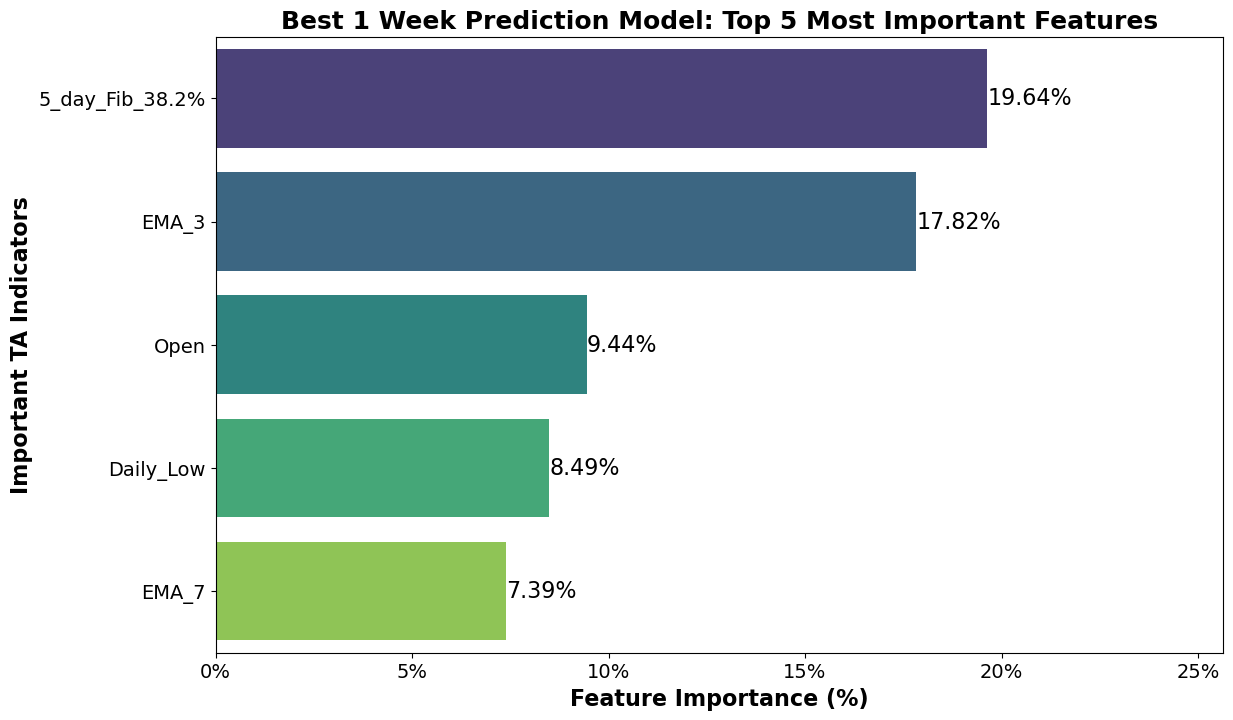

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [61]:
# PCA for 1 week best prediction model

# Scale dataset to standardizeed (mean = 0, variance = 1)
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_1_week_md_3_scaled = scaler.fit_transform(X_train_1_week_md_3)
X_test_1_week_md_3_scaled = scaler.transform(X_test_1_week_md_3)



In [62]:
# run PCA: keep enough componants to explain 99% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_week_md_3_scaled = imputer.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_scaled = imputer.transform(X_test_1_week_md_3_scaled)


# Apply PCA and keep enough components to explain 99% of variance
pca_99 = PCA(n_components=0.99)  # Retains 99% of the variance
X_train_1_week_md_3_99_pca = pca_99.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_99_pca= pca_99.transform(X_test_1_week_md_3_scaled)


# Number of components retained
print("Number of components retained for 99% variance: ", pca_99.n_components_)

Number of components retained for 99% variance:  42


In [63]:
# Train XGBoost model using PCA-transformed data
# explain 99% of the variance
model_1_week_md_3_99_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)
# Train the model
model_1_week_md_3_99_pca.fit(X_train_1_week_md_3_99_pca, y_train_1_week_md_3)

# Predict on test data
y_pred_1_week_md_3_99_pca = model_1_week_md_3_99_pca.predict(X_test_1_week_md_3_99_pca)

# Calculate MSE
mse_test_1_week_md_3_99_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_99_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_week_md_3_99_pca}')

Mean Squared Error after PCA: 5231.653450099371


In [64]:
# metrics and feature importance on unseen data
# explain 99% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_week_md_3_99_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_99_pca)
mae_1_week_md_3_99_pca = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_99_pca)
rmse_1_week_md_3_99_pca = np.sqrt(mse_1_week_md_3_99_pca)  # Root Mean Squared Error
r2_1_week_md_3_99_pca = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3_99_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3_99_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3_99_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3_99_pca}')
print(f'R-squared on unseen data: {r2_1_week_md_3_99_pca}')

# Additional metrics
medae_1_week_md_3_99_pca = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_99_pca)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3_99_pca}')

dw_stat_1_week_md_3_99_pca = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3_99_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3_99_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3_99_pca = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3_99_pca) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3_99_pca:.2f}%')



Mean Squared Error on unseen data: 5231.653450099371
Mean Absolute Error on unseen data: 23.974175610746393
Root Mean Squared Error on unseen data: 72.33016970876932
R-squared on unseen data: 0.8592725547310556
Median Absolute Error on unseen data: 5.277332305908203
Durbin-Watson Statistic on unseen data: 0.01800993349934955
MAPE on unseen data: 6.63%


In [65]:
# run PCA: keep enough componants to explain 95% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_week_md_3_scaled = imputer.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_scaled = imputer.transform(X_test_1_week_md_3_scaled)


# Apply PCA and keep enough components to explain 95% of variance
pca_95 = PCA(n_components=0.95)  # Retains 95% of the variance
X_train_1_week_md_3_95_pca = pca_95.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_95_pca= pca_95.transform(X_test_1_week_md_3_scaled)


# Number of components retained
print("Number of components retained for 95% variance: ", pca_95.n_components_)

Number of components retained for 95% variance:  17


In [66]:
# Train XGBoost model using PCA-transformed data
# explain 95% of the variance
model_1_week_md_3_95_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)
# Train the model
model_1_week_md_3_95_pca.fit(X_train_1_week_md_3_95_pca, y_train_1_week_md_3)

# Predict on test data
y_pred_1_week_md_3_95_pca = model_1_week_md_3_95_pca.predict(X_test_1_week_md_3_95_pca)

# Calculate MSE
mse_test_1_week_md_3_95_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_95_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_week_md_3_95_pca}')

Mean Squared Error after PCA: 5221.879242740223


In [67]:
# metrics and feature importance on unseen data
# explain 95% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_week_md_3_95_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_95_pca)
mae_1_week_md_3_95_pca = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_95_pca)
rmse_1_week_md_3_95_pca = np.sqrt(mse_1_week_md_3_95_pca)  # Root Mean Squared Error
r2_1_week_md_3_95_pca = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3_95_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3_95_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3_95_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3_95_pca}')
print(f'R-squared on unseen data: {r2_1_week_md_3_95_pca}')

# Additional metrics
medae_1_week_md_3_95_pca = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_95_pca)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3_95_pca}')

dw_stat_1_week_md_3_95_pca = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3_95_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3_95_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3_95_pca = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3_95_pca) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3_95_pca:.2f}%')



Mean Squared Error on unseen data: 5221.879242740223
Mean Absolute Error on unseen data: 23.999921070499642
Root Mean Squared Error on unseen data: 72.26257152039514
R-squared on unseen data: 0.8595354733750945
Median Absolute Error on unseen data: 5.371242523193359
Durbin-Watson Statistic on unseen data: 0.01795185122132385
MAPE on unseen data: 6.67%


In [68]:
# run PCA: keep enough componants to explain 90% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_week_md_3_scaled = imputer.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_scaled = imputer.transform(X_test_1_week_md_3_scaled)


# Apply PCA and keep enough components to explain 90% of variance
pca_90 = PCA(n_components=0.90)  # Retains 90% of the variance
X_train_1_week_md_3_90_pca = pca_90.fit_transform(X_train_1_week_md_3_scaled)
X_test_1_week_md_3_90_pca= pca_90.transform(X_test_1_week_md_3_scaled)


# Number of components retained
print("Number of components retained for 90% variance: ", pca_90.n_components_)

Number of components retained for 90% variance:  10


In [69]:
# Train XGBoost model using PCA-transformed data
# explain 90% of the variance
model_1_week_md_3_90_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)
# Train the model
model_1_week_md_3_90_pca.fit(X_train_1_week_md_3_90_pca, y_train_1_week_md_3)

# Predict on test data
y_pred_1_week_md_3_90_pca = model_1_week_md_3_90_pca.predict(X_test_1_week_md_3_90_pca)

# Calculate MSE
mse_test_1_week_md_3_90_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_90_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_week_md_3_90_pca}')

Mean Squared Error after PCA: 5300.6027033179325


In [70]:
# metrics and feature importance on unseen data
# explain 90% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_week_md_3_90_pca = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3_90_pca)
mae_1_week_md_3_90_pca = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_90_pca)
rmse_1_week_md_3_90_pca = np.sqrt(mse_1_week_md_3_90_pca)  # Root Mean Squared Error
r2_1_week_md_3_90_pca = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3_90_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3_90_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3_90_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3_90_pca}')
print(f'R-squared on unseen data: {r2_1_week_md_3_90_pca}')

# Additional metrics
medae_1_week_md_3_90_pca = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3_90_pca)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3_90_pca}')

dw_stat_1_week_md_3_90_pca = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3_90_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3_90_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3_90_pca = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3_90_pca) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3_90_pca:.2f}%')



Mean Squared Error on unseen data: 5300.6027033179325
Mean Absolute Error on unseen data: 24.562198258114233
Root Mean Squared Error on unseen data: 72.80523815851393
R-squared on unseen data: 0.8574178729653004
Median Absolute Error on unseen data: 5.8314056396484375
Durbin-Watson Statistic on unseen data: 0.01743184232035474
MAPE on unseen data: 6.81%


In [71]:
# now we're going to move onto our next model: 1 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_baseline = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_baseline = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_baseline['Close_Target'] = stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_baseline['Close_Target'] = stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_baseline = stock_data_train_1_month_baseline.dropna(subset=['Close_Target'])
stock_data_test_1_month_baseline = stock_data_test_1_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_baseline[numeric_cols_train] = stock_data_train_1_month_baseline[numeric_cols_train].fillna(stock_data_train_1_month_baseline[numeric_cols_train].median())
stock_data_test_1_month_baseline[numeric_cols_test] = stock_data_test_1_month_baseline[numeric_cols_test].fillna(stock_data_test_1_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_baseline.shape}")
print(f"Testing data shape: {stock_data_test_1_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_month_baseline = stock_data_train_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_baseline = stock_data_train_1_month_baseline['Close_Target']

# Create X and y for testing
X_test_1_month_baseline = stock_data_test_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_baseline = stock_data_test_1_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_baseline shape: {X_train_1_month_baseline.shape}, y_train_1_month_baseline shape: {y_train_1_month_baseline.shape}")
print(f"X_test_1_month_baseline shape: {X_test_1_month_baseline.shape}, y_test_1_month_baseline shape: {y_test_1_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_baseline.shape[0] == 0 or X_test_1_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_month.fit(X_train_1_month_baseline, y_train_1_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_baseline = model_baseline_1_month.predict(X_test_1_month_baseline)

# Calculate performance on the test data
mse_test_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_baseline}')


Training data shape: (49675, 262)
Testing data shape: (12650, 262)
X_train_1_month_baseline shape: (49675, 258), y_train_1_month_baseline shape: (49675,)
X_test_1_month_baseline shape: (12650, 258), y_test_1_month_baseline shape: (12650,)
Mean Squared Error on unseen data (post-February 10, 2024): 7736.662331599638


In [72]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_baseline` are your predictions for the test data and `y_test_1_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
mae_1_month_baseline = mean_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
rmse_1_month_baseline = np.sqrt(mse_1_month_baseline)  # Root Mean Squared Error
r2_1_month_baseline = r2_score(y_test_1_month_baseline, y_pred_1_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_baseline}')
print(f'R-squared on unseen data: {r2_1_month_baseline}')

# Additional metrics
medae_1_month_baseline = median_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_month_baseline}')

dw_stat_1_month_baseline = durbin_watson(y_test_1_month_baseline - y_pred_1_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_baseline = np.mean(np.abs((y_test_1_month_baseline - y_pred_1_month_baseline) / y_test_1_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_baseline = dict(zip(X_train_1_month_baseline.columns, model_baseline_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_baseline = sorted(feature_importance_1_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7736.662331599638
Mean Absolute Error on unseen data: 33.84374066198296
Root Mean Squared Error on unseen data: 87.95829882165546
R-squared on unseen data: 0.793330721064659
Median Absolute Error on unseen data: 9.28131103515625
Durbin-Watson Statistic on unseen data: 0.01222767236844741
MAPE on unseen data: 9.13%
EMA_30: 43.29%
Daily_Low: 13.79%
Daily_High: 12.24%
5_day_Fib_23.6%: 4.87%
EMA_10: 4.73%
14_day_Fib_23.6%: 4.27%
30_day_Fib_38.2%: 2.81%
EMA_30_lag_7: 2.57%
30_day_Fib_100.0%: 2.09%
Rolling_Quantile_75_30: 1.62%
30_day_Fib_23.6%: 0.83%
Upper_Band_30: 0.77%
Daily_High_30day_avg: 0.66%
Lower_Band_7: 0.47%
5_day_Fib_161.8%: 0.40%
Rolling_Median_30: 0.39%
5_day_Fib_61.8%: 0.27%
5_day_Fib_38.2%: 0.23%
Rolling_Quantile_25_21: 0.22%
14_day_Fib_78.6%: 0.20%
EMA_30_lag_5: 0.19%
Upper_Band_10: 0.16%
Rolling_Quantile_25_10: 0.14%
5_day_Fib_78.6%: 0.12%
30_day_Fib_61.8%: 0.12%
Rolling_Quantile_25_7: 0.11%
Daily_High_10day_avg: 0.10%
Open: 0.10%
14_day_F

In [73]:
# 1 month baseline model with learning_rate=0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_lr_1 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_lr_1 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_lr_1['Close_Target'] = stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_lr_1['Close_Target'] = stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_lr_1 = stock_data_train_1_month_lr_1.dropna(subset=['Close_Target'])
stock_data_test_1_month_lr_1 = stock_data_test_1_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_lr_1[numeric_cols_train] = stock_data_train_1_month_lr_1[numeric_cols_train].fillna(stock_data_train_1_month_lr_1[numeric_cols_train].median())
stock_data_test_1_month_lr_1[numeric_cols_test] = stock_data_test_1_month_lr_1[numeric_cols_test].fillna(stock_data_test_1_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_1_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_1 = stock_data_train_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_1 = stock_data_train_1_month_lr_1['Close_Target']

# Create X and y for testing
X_test_1_month_lr_1 = stock_data_test_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_1 = stock_data_test_1_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_1 shape: {X_train_1_month_lr_1.shape}, y_train_1_month_lr_1 shape: {y_train_1_month_lr_1.shape}")
print(f"X_test_1_month_lr_1 shape: {X_test_1_month_lr_1.shape}, y_test_1_month_lr_1 shape: {y_test_1_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_1.shape[0] == 0 or X_test_1_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_lr_1.fit(X_train_1_month_lr_1, y_train_1_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_1 = model_1_month_lr_1.predict(X_test_1_month_lr_1)

# Calculate performance on the test data
mse_test_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_1}')


Training data shape: (49675, 262)
Testing data shape: (12650, 262)
X_train_1_month_lr_1 shape: (49675, 258), y_train_1_month_lr_1 shape: (49675,)
X_test_1_month_lr_1 shape: (12650, 258), y_test_1_month_lr_1 shape: (12650,)
Mean Squared Error on unseen data (post-February 10, 2024): 7579.979188163184


In [74]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_lr_1` are your predictions for the test data and `y_test_1_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
mae_1_month_lr_1 = mean_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
rmse_1_month_lr_1 = np.sqrt(mse_1_month_lr_1)  # Root Mean Squared Error
r2_1_month_lr_1 = r2_score(y_test_1_month_lr_1, y_pred_1_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_lr_1}')
print(f'R-squared on unseen data: {r2_1_month_lr_1}')

# Additional metrics
medae_1_month_lr_1 = median_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_1}')

dw_stat_1_month_lr_1 = durbin_watson(y_test_1_month_lr_1 - y_pred_1_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_1 = np.mean(np.abs((y_test_1_month_lr_1 - y_pred_1_month_lr_1) / y_test_1_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_lr_1 = dict(zip(X_train_1_month_lr_1.columns, model_1_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_1 = sorted(feature_importance_1_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7579.979188163184
Mean Absolute Error on unseen data: 33.94572083620215
Root Mean Squared Error on unseen data: 87.06307591719457
R-squared on unseen data: 0.7975161941908512
Median Absolute Error on unseen data: 9.886566162109375
Durbin-Watson Statistic on unseen data: 0.012605495572799797
MAPE on unseen data: 9.43%
EMA_30: 34.46%
Daily_Low: 17.86%
Daily_High: 16.87%
EMA_10: 5.90%
30_day_Fib_38.2%: 3.88%
5_day_Fib_23.6%: 3.46%
14_day_Fib_23.6%: 2.87%
EMA_30_lag_7: 2.28%
30_day_Fib_100.0%: 2.00%
Rolling_Quantile_75_30: 1.97%
Upper_Band_30: 1.17%
30_day_Fib_23.6%: 0.93%
Daily_High_30day_avg: 0.74%
Rolling_Median_30: 0.50%
Lower_Band_7: 0.44%
5_day_Fib_161.8%: 0.43%
5_day_Fib_78.6%: 0.36%
14_day_Fib_78.6%: 0.27%
5_day_Fib_38.2%: 0.24%
Upper_Band_10: 0.24%
Rolling_Quantile_25_7: 0.23%
30_day_Fib_61.8%: 0.23%
Rolling_Quantile_25_21: 0.18%
SMA_30_lag_20: 0.14%
Open: 0.12%
Lower_Band_21: 0.10%
30_day_Fib_50.0%: 0.10%
14_day_Fib_61.8%: 0.09%
5_day_Fib_50.0%:

In [75]:
# 1 month baseline model with learning_rate=0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_lr_01 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_lr_01 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_lr_01['Close_Target'] = stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_lr_01['Close_Target'] = stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_lr_01 = stock_data_train_1_month_lr_01.dropna(subset=['Close_Target'])
stock_data_test_1_month_lr_01 = stock_data_test_1_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_lr_01[numeric_cols_train] = stock_data_train_1_month_lr_01[numeric_cols_train].fillna(stock_data_train_1_month_lr_01[numeric_cols_train].median())
stock_data_test_1_month_lr_01[numeric_cols_test] = stock_data_test_1_month_lr_01[numeric_cols_test].fillna(stock_data_test_1_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_1_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_01 = stock_data_train_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_01 = stock_data_train_1_month_lr_01['Close_Target']

# Create X and y for testing
X_test_1_month_lr_01 = stock_data_test_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_01 = stock_data_test_1_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_01 shape: {X_train_1_month_lr_01.shape}, y_train_1_month_lr_01 shape: {y_train_1_month_lr_01.shape}")
print(f"X_test_1_month_lr_01 shape: {X_test_1_month_lr_01.shape}, y_test_1_month_lr_01 shape: {y_test_1_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_01.shape[0] == 0 or X_test_1_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_lr_01.fit(X_train_1_month_lr_01, y_train_1_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_01 = model_1_month_lr_01.predict(X_test_1_month_lr_01)

# Calculate performance on the test data
mse_test_1_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_01}')


Training data shape: (49675, 262)
Testing data shape: (12650, 262)
X_train_1_month_lr_01 shape: (49675, 258), y_train_1_month_lr_01 shape: (49675,)
X_test_1_month_lr_01 shape: (12650, 258), y_test_1_month_lr_01 shape: (12650,)
Mean Squared Error on unseen data (post-February 10, 2024): 7401.99486115928


In [76]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_lr_01` are your predictions for the test data and `y_test_1_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
mae_1_month_lr_01 = mean_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
rmse_month_lr_01 = np.sqrt(mse_month_lr_01)  # Root Mean Squared Error
r2_month_lr_01 = r2_score(y_test_1_month_lr_01, y_pred_1_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_month_lr_01}')
print(f'R-squared on unseen data: {r2_month_lr_01}')

# Additional metrics
medae_1_month_lr_01 = median_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_01}')

dw_stat_1_month_lr_01 = durbin_watson(y_test_1_month_lr_01 - y_pred_1_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_01 = np.mean(np.abs((y_test_1_month_lr_01 - y_pred_1_month_lr_01) / y_test_1_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_month_lr_01 = dict(zip(X_train_1_month_lr_01.columns, model_1_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_01 = sorted(feature_importance_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7401.99486115928
Mean Absolute Error on unseen data: 32.552598773971376
Root Mean Squared Error on unseen data: 86.03484678407511
R-squared on unseen data: 0.8022706853327806
Median Absolute Error on unseen data: 8.777885437011719
Durbin-Watson Statistic on unseen data: 0.012005752728029688
MAPE on unseen data: 8.69%
EMA_30: 44.66%
Daily_Low: 9.17%
Daily_High: 7.52%
30_day_Fib_38.2%: 4.85%
EMA_10: 4.43%
5_day_Fib_23.6%: 4.28%
14_day_Fib_23.6%: 4.26%
EMA_30_lag_7: 2.88%
30_day_Fib_100.0%: 2.77%
Rolling_Quantile_75_30: 2.26%
Upper_Band_30: 1.49%
Daily_High_30day_avg: 1.07%
30_day_Fib_23.6%: 0.93%
EMA_14_lag_10: 0.71%
Lower_Band_7: 0.69%
Rolling_Median_30: 0.49%
EMA_7: 0.44%
5_day_Fib_161.8%: 0.42%
Rolling_Quantile_25_21: 0.39%
Open: 0.36%
5_day_Fib_38.2%: 0.30%
Close_lag_1: 0.29%
14_day_Fib_78.6%: 0.28%
Upper_Band_10: 0.27%
EMA_30_lag_5: 0.21%
SMA_10: 0.19%
30_day_Fib_61.8%: 0.17%
30_day_Fib_50.0%: 0.17%
Rolling_Quantile_75_21: 0.16%
EMA_30_lag_10: 0.15

update 02-25-2025
lr= 0.01 was always best, but when i ran it this time, lr = 0.1 was best. however, higher learning rate can lead to overfitting. so we are going to change it to learning rate = 0.01

In [77]:
# model with learning_rate = 0.01
# now we'll do max depth
# max depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_md_3 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_md_3 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_md_3['Close_Target'] = stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_md_3['Close_Target'] = stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_md_3 = stock_data_train_1_month_md_3.dropna(subset=['Close_Target'])
stock_data_test_1_month_md_3 = stock_data_test_1_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_md_3[numeric_cols_train] = stock_data_train_1_month_md_3[numeric_cols_train].fillna(stock_data_train_1_month_md_3[numeric_cols_train].median())
stock_data_test_1_month_md_3[numeric_cols_test] = stock_data_test_1_month_md_3[numeric_cols_test].fillna(stock_data_test_1_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_md_3.shape}")
print(f"Testing data shape: {stock_data_test_1_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_3 = stock_data_train_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_3 = stock_data_train_1_month_md_3['Close_Target']

# Create X and y for testing
X_test_1_month_md_3 = stock_data_test_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_3 = stock_data_test_1_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_3 shape: {X_train_1_month_md_3.shape}, y_train_1_month_md_3 shape: {y_train_1_month_md_3.shape}")
print(f"X_test_1_month_md_3 shape: {X_test_1_month_md_3.shape}, y_test_1_month_md_3 shape: {y_test_1_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_3.shape[0] == 0 or X_test_1_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_3.fit(X_train_1_month_md_3, y_train_1_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_3 = model_1_month_md_3.predict(X_test_1_month_md_3)

# Calculate performance on the test data
mse_test_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_3}')


Training data shape: (49675, 262)
Testing data shape: (12650, 262)
X_train_1_month_md_3 shape: (49675, 258), y_train_1_month_md_3 shape: (49675,)
X_test_1_month_md_3 shape: (12650, 258), y_test_1_month_md_3 shape: (12650,)
Mean Squared Error on unseen data (post-February 10, 2024): 6499.7239634649


In [78]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_md_3` are your predictions for the test data and `y_test_1_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
mae_1_month_md_3 = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
rmse_1_month_md_3 = np.sqrt(mse_1_month_md_3)  # Root Mean Squared Error
r2_1_month_md_3 = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3}')
print(f'R-squared on unseen data: {r2_1_month_md_3}')

# Additional metrics
medae_1_month_md_3 = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3}')

dw_stat_1_month_md_3 = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3 = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_3 = dict(zip(X_train_1_month_md_3.columns, model_1_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_3 = sorted(feature_importance_1_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 6499.7239634649
Mean Absolute Error on unseen data: 30.138352328816893
Root Mean Squared Error on unseen data: 80.62086555889177
R-squared on unseen data: 0.8263730266058661
Median Absolute Error on unseen data: 8.176628112792969
Durbin-Watson Statistic on unseen data: 0.01237821443652139
MAPE on unseen data: 8.04%
Upper_Band_21: 14.06%
EMA_30: 11.21%
5_day_Fib_50.0%: 10.08%
Daily_High: 7.07%
Daily_Low: 4.82%
30_day_Fib_61.8%: 4.20%
Daily_Low_10day_avg: 3.74%
5_day_Fib_23.6%: 3.59%
Daily_Low_14day_avg: 3.00%
5_day_Fib_38.2%: 2.86%
Upper_Band_30: 2.80%
EMA_30_lag_7: 2.71%
Rolling_Quantile_75_30: 2.71%
5_day_Fib_100.0%: 2.33%
Open: 2.33%
30_day_Fib_100.0%: 1.86%
Daily_High_21day_avg: 1.71%
EMA_7: 1.41%
EMA_10: 1.40%
14_day_Fib_23.6%: 1.17%
30_day_Fib_23.6%: 1.08%
EMA_14: 1.08%
EMA_30_lag_5: 1.01%
Lower_Band_7: 0.99%
14_day_Fib_100.0%: 0.99%
30_day_Fib_38.2%: 0.90%
Close_lag_1: 0.76%
VWAP_lag_5: 0.65%
Rolling_Median_30: 0.51%
SMA_14_lag_2: 0.45%
Daily_Hi

In [79]:
# model with learning_rate = 0.01
# now we'll do max depth
# max depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_md_7 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_md_7 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_md_7['Close_Target'] = stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_md_7['Close_Target'] = stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_md_7 = stock_data_train_1_month_md_7.dropna(subset=['Close_Target'])
stock_data_test_1_month_md_7 = stock_data_test_1_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_md_7[numeric_cols_train] = stock_data_train_1_month_md_7[numeric_cols_train].fillna(stock_data_train_1_month_md_7[numeric_cols_train].median())
stock_data_test_1_month_md_7[numeric_cols_test] = stock_data_test_1_month_md_7[numeric_cols_test].fillna(stock_data_test_1_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_md_7.shape}")
print(f"Testing data shape: {stock_data_test_1_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_7 = stock_data_train_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_7 = stock_data_train_1_month_md_7['Close_Target']

# Create X and y for testing
X_test_1_month_md_7 = stock_data_test_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_7 = stock_data_test_1_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_7 shape: {X_train_1_month_md_7.shape}, y_train_1_month_md_7 shape: {y_train_1_month_md_7.shape}")
print(f"X_test_1_month_md_7 shape: {X_test_1_month_md_7.shape}, y_test_1_month_md_7 shape: {y_test_1_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_7.shape[0] == 0 or X_test_1_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_7.fit(X_train_1_month_md_7, y_train_1_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_7 = model_1_month_md_7.predict(X_test_1_month_md_7)

# Calculate performance on the test data
mse_test_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_7}')


Training data shape: (49675, 262)
Testing data shape: (12650, 262)
X_train_1_month_md_7 shape: (49675, 258), y_train_1_month_md_7 shape: (49675,)
X_test_1_month_md_7 shape: (12650, 258), y_test_1_month_md_7 shape: (12650,)
Mean Squared Error on unseen data (post-February 10, 2024): 7354.632167744306


In [80]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_md_7` are your predictions for the test data and `y_test_1_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
mae_1_month_md_7 = mean_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
rmse_1_month_md_7 = np.sqrt(mse_1_month_md_7)  # Root Mean Squared Error
r2_1_month_md_7 = r2_score(y_test_1_month_md_7, y_pred_1_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_7}')
print(f'R-squared on unseen data: {r2_1_month_md_7}')

# Additional metrics
medae_1_month_md_7 = median_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_7}')

dw_stat_1_month_md_7 = durbin_watson(y_test_1_month_md_7 - y_pred_1_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_7 = np.mean(np.abs((y_test_1_month_md_7 - y_pred_1_month_md_7) / y_test_1_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_7 = dict(zip(X_train_1_month_md_7.columns, model_1_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_7 = sorted(feature_importance_1_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7354.632167744306
Mean Absolute Error on unseen data: 32.80591167781664
Root Mean Squared Error on unseen data: 85.75915209319822
R-squared on unseen data: 0.8035358838482345
Median Absolute Error on unseen data: 9.043079376220703
Durbin-Watson Statistic on unseen data: 0.012515867201484754
MAPE on unseen data: 8.81%
EMA_30: 19.29%
Daily_High: 16.63%
Daily_Low: 16.47%
EMA_10: 7.93%
14_day_Fib_23.6%: 7.67%
Rolling_Quantile_75_30: 5.61%
30_day_Fib_38.2%: 4.99%
Rolling_Quantile_25_7: 2.44%
EMA_30_lag_7: 2.14%
30_day_Fib_100.0%: 2.11%
Rolling_Median_30: 1.13%
5_day_Fib_23.6%: 1.02%
30_day_Fib_23.6%: 0.96%
5_day_Fib_161.8%: 0.85%
EMA_30_lag_10: 0.77%
EMA_21: 0.73%
5_day_Fib_61.8%: 0.65%
Upper_Band_21: 0.65%
EMA_14_lag_10: 0.62%
14_day_Fib_61.8%: 0.47%
EMA_7: 0.39%
Rolling_Quantile_75_7: 0.38%
5_day_Fib_38.2%: 0.37%
Upper_Band_30: 0.37%
Rolling_Quantile_25_21: 0.37%
Lower_Band_7: 0.28%
5_day_Fib_78.6%: 0.27%
Close_lag_20: 0.25%
Rolling_Quantile_75_21: 0.24%

# best 1 month prediction model:
* learning_rate = 0.01
* max_depth = 3
* model_1_month_md_3

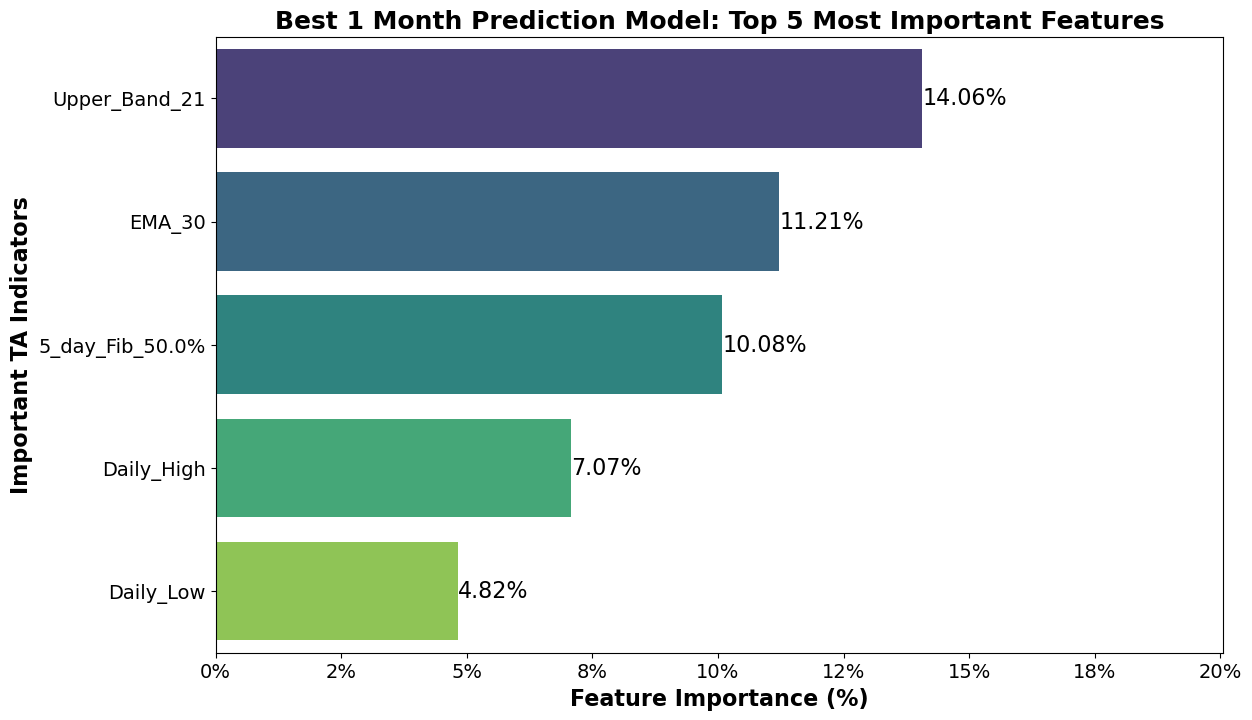

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


Mean Squared Error on unseen data: 11421.348046975427
Mean Absolute Error on unseen data: 22.514261429763494
Root Mean Squared Error on unseen data: 106.8707071510965
R-squared on unseen data: 0.885555380218952
Median Absolute Error on unseen data: 5.6576385498046875
Durbin-Watson Statistic on unseen data: 0.016962207847222594
MAPE on unseen data: 6.61%

In [82]:
# PCA for 1 month best prediction model

# Scale dataset to standardizeed (mean = 0, variance = 1)
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_1_month_md_3_scaled = scaler.fit_transform(X_train_1_month_md_3)
X_test_1_month_md_3_scaled = scaler.transform(X_test_1_month_md_3)

In [83]:
# run PCA: keep enough componants to explain 99% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_month_md_3_scaled = imputer.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_scaled = imputer.transform(X_test_1_month_md_3_scaled)


# Apply PCA and keep enough components to explain 99% of variance
pca_99 = PCA(n_components=0.99)  # Retains 99% of the variance
X_train_1_month_md_3_99_pca = pca_99.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_99_pca= pca_99.transform(X_test_1_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 99% variance: ", pca_99.n_components_)

Number of components retained for 99% variance:  42


In [84]:
# Train XGBoost model using PCA-transformed data
# explain 99% of the variance
model_1_month_md_3_99_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)

# Train the model
model_1_month_md_3_99_pca.fit(X_train_1_month_md_3_99_pca, y_train_1_month_md_3)

# Predict on test data
y_pred_1_month_md_3_99_pca = model_1_month_md_3_99_pca.predict(X_test_1_month_md_3_99_pca)

# Calculate MSE
mse_test_1_month_md_3_99_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_99_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_month_md_3_99_pca}')

Mean Squared Error after PCA: 6186.556651148134


In [85]:
# metrics and feature importance on unseen data
# explain 99% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_month_md_3_99_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_99_pca)
mae_1_month_md_3_99_pca = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_99_pca)
rmse_1_month_md_3_99_pca = np.sqrt(mse_1_month_md_3_99_pca)  # Root Mean Squared Error
r2_1_month_md_3_99_pca = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3_99_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3_99_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3_99_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3_99_pca}')
print(f'R-squared on unseen data: {r2_1_month_md_3_99_pca}')

# Additional metrics
medae_1_month_md_3_99_pca = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_99_pca)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3_99_pca}')

dw_stat_1_month_md_3_99_pca = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3_99_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3_99_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3_99_pca = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3_99_pca) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3_99_pca:.2f}%')



Mean Squared Error on unseen data: 6186.556651148134
Mean Absolute Error on unseen data: 30.770384253701675
Root Mean Squared Error on unseen data: 78.65466706526787
R-squared on unseen data: 0.8347386576556114
Median Absolute Error on unseen data: 9.803787231445312
Durbin-Watson Statistic on unseen data: 0.014790813420716132
MAPE on unseen data: 9.39%


In [86]:
# run PCA: keep enough componants to explain 95% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_month_md_3_scaled = imputer.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_scaled = imputer.transform(X_test_1_month_md_3_scaled)


# Apply PCA and keep enough components to explain 95% of variance
pca_95 = PCA(n_components=0.95)  # Retains 95% of the variance
X_train_1_month_md_3_95_pca = pca_95.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_95_pca= pca_95.transform(X_test_1_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 95% variance: ", pca_95.n_components_)

Number of components retained for 95% variance:  14


In [87]:
# Train XGBoost model using PCA-transformed data
# explain 95% of the variance
model_1_month_md_3_95_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)


# Train the model
model_1_month_md_3_95_pca.fit(X_train_1_month_md_3_95_pca, y_train_1_month_md_3)

# Predict on test data
y_pred_1_month_md_3_95_pca = model_1_month_md_3_95_pca.predict(X_test_1_month_md_3_95_pca)

# Calculate MSE
mse_test_1_month_md_3_95_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_95_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_month_md_3_95_pca}')

Mean Squared Error after PCA: 6153.563140921443


In [88]:
# metrics and feature importance on unseen data
# explain 95% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_month_md_3_95_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_95_pca)
mae_1_month_md_3_95_pca = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_95_pca)
rmse_1_month_md_3_95_pca = np.sqrt(mse_1_month_md_3_95_pca)  # Root Mean Squared Error
r2_1_month_md_3_95_pca = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3_95_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3_95_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3_95_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3_95_pca}')
print(f'R-squared on unseen data: {r2_1_month_md_3_95_pca}')

# Additional metrics
medae_1_month_md_3_95_pca = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_95_pca)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3_95_pca}')

dw_stat_1_month_md_3_95_pca = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3_95_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3_95_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3_95_pca = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3_95_pca) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3_95_pca:.2f}%')



Mean Squared Error on unseen data: 6153.563140921443
Mean Absolute Error on unseen data: 30.730560123157126
Root Mean Squared Error on unseen data: 78.44465017400131
R-squared on unseen data: 0.8356200125184501
Median Absolute Error on unseen data: 9.807029724121094
Durbin-Watson Statistic on unseen data: 0.01476556246143638
MAPE on unseen data: 9.42%


In [89]:
# run PCA: keep enough componants to explain 90% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_1_month_md_3_scaled = imputer.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_scaled = imputer.transform(X_test_1_month_md_3_scaled)


# Apply PCA and keep enough components to explain 90% of variance
pca_90 = PCA(n_components=0.90)  # Retains 90% of the variance
X_train_1_month_md_3_90_pca = pca_90.fit_transform(X_train_1_month_md_3_scaled)
X_test_1_month_md_3_90_pca= pca_90.transform(X_test_1_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 90% variance: ", pca_90.n_components_)

Number of components retained for 90% variance:  8


In [90]:
# Train XGBoost model using PCA-transformed data
# explain 90% of the variance
model_1_month_md_3_90_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)
# Train the model
model_1_month_md_3_90_pca.fit(X_train_1_month_md_3_90_pca, y_train_1_month_md_3)

# Predict on test data
y_pred_1_month_md_3_90_pca = model_1_month_md_3_90_pca.predict(X_test_1_month_md_3_90_pca)

# Calculate MSE
mse_test_1_month_md_3_90_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_90_pca)
print(f'Mean Squared Error after PCA: {mse_test_1_month_md_3_90_pca}')

Mean Squared Error after PCA: 6708.2787787640145


In [91]:
# metrics and feature importance on unseen data
# explain 90% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_1_month_md_3_90_pca = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3_90_pca)
mae_1_month_md_3_90_pca = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_90_pca)
rmse_1_month_md_3_90_pca = np.sqrt(mse_1_month_md_3_90_pca)  # Root Mean Squared Error
r2_1_month_md_3_90_pca = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3_90_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3_90_pca}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3_90_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3_90_pca}')
print(f'R-squared on unseen data: {r2_1_month_md_3_90_pca}')

# Additional metrics
medae_1_month_md_3_90_pca = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3_90_pca)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3_90_pca}')

dw_stat_1_month_md_3_90_pca = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3_90_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3_90_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3_90_pca = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3_90_pca) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3_90_pca:.2f}%')



Mean Squared Error on unseen data: 6708.2787787640145
Mean Absolute Error on unseen data: 32.46703004769186
Root Mean Squared Error on unseen data: 81.90408279667146
R-squared on unseen data: 0.820801906728976
Median Absolute Error on unseen data: 10.41385269165039
Durbin-Watson Statistic on unseen data: 0.013374188826438493
MAPE on unseen data: 10.25%


In [92]:
# now we're going to move onto our next model: 3 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_baseline = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_baseline = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_baseline['Close_Target'] = stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_baseline['Close_Target'] = stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_baseline = stock_data_train_3_month_baseline.dropna(subset=['Close_Target'])
stock_data_test_3_month_baseline = stock_data_test_3_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_baseline[numeric_cols_train] = stock_data_train_3_month_baseline[numeric_cols_train].fillna(stock_data_train_3_month_baseline[numeric_cols_train].median())
stock_data_test_3_month_baseline[numeric_cols_test] = stock_data_test_3_month_baseline[numeric_cols_test].fillna(stock_data_test_3_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_baseline.shape}")
print(f"Testing data shape: {stock_data_test_3_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_3_month_baseline = stock_data_train_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_baseline = stock_data_train_3_month_baseline['Close_Target']

# Create X and y for testing
X_test_3_month_baseline = stock_data_test_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_baseline = stock_data_test_3_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_baseline shape: {X_train_3_month_baseline.shape}, y_train_3_month_baseline shape: {y_train_3_month_baseline.shape}")
print(f"X_test_3_month_baseline shape: {X_test_3_month_baseline.shape}, y_test_3_month_baseline shape: {y_test_3_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_baseline.shape[0] == 0 or X_test_3_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_3_month.fit(X_train_3_month_baseline, y_train_3_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_baseline = model_baseline_3_month.predict(X_test_3_month_baseline)

# Calculate performance on the test data
mse_test_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_baseline}')


Training data shape: (47425, 270)
Testing data shape: (11825, 270)
X_train_3_month_baseline shape: (47425, 266), y_train_3_month_baseline shape: (47425,)
X_test_3_month_baseline shape: (11825, 266), y_test_3_month_baseline shape: (11825,)
Mean Squared Error on unseen data (post-February 10, 2024): 9102.978512105989


In [93]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_baseline` are your predictions for the test data and `y_test_3_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
mae_3_month_baseline = mean_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
rmse_3_month_baseline = np.sqrt(mse_3_month_baseline)  # Root Mean Squared Error
r2_3_month_baseline = r2_score(y_test_3_month_baseline, y_pred_3_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_baseline}')
print(f'R-squared on unseen data: {r2_3_month_baseline}')

# Additional metrics
medae_3_month_baseline = median_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_3_month_baseline}')

dw_stat_3_month_baseline = durbin_watson(y_test_3_month_baseline - y_pred_3_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_baseline = np.mean(np.abs((y_test_3_month_baseline - y_pred_3_month_baseline) / y_test_3_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_3_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_baseline = dict(zip(X_train_3_month_baseline.columns, model_baseline_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_baseline = sorted(feature_importance_3_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9102.978512105989
Mean Absolute Error on unseen data: 43.28427520122891
Root Mean Squared Error on unseen data: 95.40953050982898
R-squared on unseen data: 0.7642832929081471
Median Absolute Error on unseen data: 14.546730041503906
Durbin-Watson Statistic on unseen data: 0.00977553247659201
MAPE on unseen data: 13.06%
Upper_Band_90: 16.19%
Upper_Band_21: 14.80%
30_day_Fib_38.2%: 9.84%
Daily_High: 9.34%
14_day_Fib_38.2%: 5.81%
Rolling_Quantile_25_50: 5.76%
5_day_Fib_23.6%: 5.19%
5_day_Fib_78.6%: 5.08%
30_day_Fib_100.0%: 3.58%
Daily_Low: 2.62%
Upper_Band_60: 2.51%
14_day_Fib_100.0%: 2.24%
14_day_Fib_61.8%: 2.10%
EMA_30_lag_10: 1.58%
30_day_Fib_23.6%: 1.43%
Upper_Band_50: 1.07%
30_day_Fib_50.0%: 0.98%
EMA_50: 0.83%
EMA_21: 0.77%
EMA_30: 0.65%
14_day_Fib_50.0%: 0.58%
5_day_Fib_38.2%: 0.55%
SMA_30: 0.52%
5_day_Fib_100.0%: 0.39%
30_day_Fib_61.8%: 0.36%
Open: 0.34%
SMA_50: 0.28%
Lower_Band_21: 0.28%
Rolling_Quantile_75_30: 0.20%
30_day_Fib_161.8%: 0.19%
14_d

In [94]:
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_lr_1 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_lr_1 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_lr_1['Close_Target'] = stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_lr_1['Close_Target'] = stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_lr_1 = stock_data_train_3_month_lr_1.dropna(subset=['Close_Target'])
stock_data_test_3_month_lr_1 = stock_data_test_3_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_lr_1[numeric_cols_train] = stock_data_train_3_month_lr_1[numeric_cols_train].fillna(stock_data_train_3_month_lr_1[numeric_cols_train].median())
stock_data_test_3_month_lr_1[numeric_cols_test] = stock_data_test_3_month_lr_1[numeric_cols_test].fillna(stock_data_test_3_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_3_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_1 = stock_data_train_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_1 = stock_data_train_3_month_lr_1['Close_Target']

# Create X and y for testing
X_test_3_month_lr_1 = stock_data_test_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_1 = stock_data_test_3_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_1 shape: {X_train_3_month_lr_1.shape}, y_train_3_month_lr_1 shape: {y_train_3_month_lr_1.shape}")
print(f"X_test_3_month_lr_1 shape: {X_test_3_month_lr_1.shape}, y_test_3_month_lr_1 shape: {y_test_3_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_1.shape[0] == 0 or X_test_3_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_lr_1.fit(X_train_3_month_lr_1, y_train_3_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_1 = model_3_month_lr_1.predict(X_test_3_month_lr_1)

# Calculate performance on the test data
mse_test_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_1}')


Training data shape: (47425, 270)
Testing data shape: (11825, 270)
X_train_3_month_lr_1 shape: (47425, 266), y_train_3_month_lr_1 shape: (47425,)
X_test_3_month_lr_1 shape: (11825, 266), y_test_3_month_lr_1 shape: (11825,)
Mean Squared Error on unseen data (post-February 10, 2024): 8809.878275026607


In [95]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_1` are your predictions for the test data and `y_test_3_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
mae_3_month_lr_1 = mean_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
rmse_3_month_lr_1 = np.sqrt(mse_3_month_lr_1)  # Root Mean Squared Error
r2_3_month_lr_1 = r2_score(y_test_3_month_lr_1, y_pred_3_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_1}')
print(f'R-squared on unseen data: {r2_3_month_lr_1}')

# Additional metrics
medae_3_month_lr_1 = median_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_1}')

dw_stat_3_month_lr_1 = durbin_watson(y_test_3_month_lr_1 - y_pred_3_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_1 = np.mean(np.abs((y_test_3_month_lr_1 - y_pred_3_month_lr_1) / y_test_3_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_1 = dict(zip(X_train_3_month_lr_1.columns, model_3_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_1 = sorted(feature_importance_3_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 8809.878275026607
Mean Absolute Error on unseen data: 42.752983497797054
Root Mean Squared Error on unseen data: 93.86095181185095
R-squared on unseen data: 0.7718729650841621
Median Absolute Error on unseen data: 14.865470886230469
Durbin-Watson Statistic on unseen data: 0.010146145047787153
MAPE on unseen data: 13.10%
Upper_Band_21: 22.82%
Upper_Band_90: 19.75%
Daily_High: 8.39%
30_day_Fib_38.2%: 8.26%
5_day_Fib_23.6%: 5.70%
Rolling_Quantile_25_50: 5.15%
14_day_Fib_38.2%: 3.61%
Upper_Band_60: 3.44%
14_day_Fib_100.0%: 3.08%
5_day_Fib_78.6%: 2.87%
30_day_Fib_100.0%: 2.38%
Daily_Low: 1.82%
EMA_50: 1.42%
30_day_Fib_23.6%: 1.33%
EMA_21: 1.14%
EMA_30_lag_10: 1.06%
14_day_Fib_50.0%: 0.93%
14_day_Fib_61.8%: 0.89%
30_day_Fib_50.0%: 0.64%
SMA_30: 0.53%
Upper_Band_50: 0.51%
30_day_Fib_61.8%: 0.36%
Rolling_Quantile_25_21: 0.25%
Rolling_Quantile_25_90: 0.22%
30_day_Fib_161.8%: 0.21%
SMA_90_lag_40: 0.17%
Rolling_Quantile_75_30: 0.14%
Rolling_Median_90: 0.13%
30_d

In [96]:
# learning rate = 0.01
# this is the best one again
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_lr_01 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_lr_01 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_lr_01['Close_Target'] = stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_lr_01['Close_Target'] = stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_lr_01 = stock_data_train_3_month_lr_01.dropna(subset=['Close_Target'])
stock_data_test_3_month_lr_01 = stock_data_test_3_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_lr_01[numeric_cols_train] = stock_data_train_3_month_lr_01[numeric_cols_train].fillna(stock_data_train_3_month_lr_01[numeric_cols_train].median())
stock_data_test_3_month_lr_01[numeric_cols_test] = stock_data_test_3_month_lr_01[numeric_cols_test].fillna(stock_data_test_3_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_3_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_01 = stock_data_train_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_01 = stock_data_train_3_month_lr_01['Close_Target']

# Create X and y for testing
X_test_3_month_lr_01 = stock_data_test_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_01 = stock_data_test_3_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_01 shape: {X_train_3_month_lr_01.shape}, y_train_3_month_lr_01 shape: {y_train_3_month_lr_01.shape}")
print(f"X_test_3_month_lr_01 shape: {X_test_3_month_lr_01.shape}, y_test_3_month_lr_01 shape: {y_test_3_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_01.shape[0] == 0 or X_test_3_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_lr_01.fit(X_train_3_month_lr_01, y_train_3_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_01 = model_3_month_lr_01.predict(X_test_3_month_lr_01)

# Calculate performance on the test data
mse_test_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_01}')


Training data shape: (47425, 270)
Testing data shape: (11825, 270)
X_train_3_month_lr_01 shape: (47425, 266), y_train_3_month_lr_01 shape: (47425,)
X_test_3_month_lr_01 shape: (11825, 266), y_test_3_month_lr_01 shape: (11825,)
Mean Squared Error on unseen data (post-February 10, 2024): 9055.148596431456


In [97]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_01` are your predictions for the test data and `y_test_3_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
mae_3_month_lr_01 = mean_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
rmse_3_month_lr_01 = np.sqrt(mse_3_month_lr_01)  # Root Mean Squared Error
r2_3_month_lr_01 = r2_score(y_test_3_month_lr_01, y_pred_3_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_01}')
print(f'R-squared on unseen data: {r2_3_month_lr_01}')

# Additional metrics
medae_3_month_lr_01 = median_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_01}')

dw_stat_3_month_lr_01 = durbin_watson(y_test_3_month_lr_01 - y_pred_3_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_01 = np.mean(np.abs((y_test_3_month_lr_01 - y_pred_3_month_lr_01) / y_test_3_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_01 = dict(zip(X_train_3_month_lr_01.columns, model_3_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_01 = sorted(feature_importance_3_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 9055.148596431456
Mean Absolute Error on unseen data: 42.74225906484979
Root Mean Squared Error on unseen data: 95.15854452665539
R-squared on unseen data: 0.765521822715538
Median Absolute Error on unseen data: 14.09765625
Durbin-Watson Statistic on unseen data: 0.009625211436543544
MAPE on unseen data: 12.73%
Upper_Band_90: 17.20%
Upper_Band_21: 13.48%
30_day_Fib_38.2%: 11.60%
14_day_Fib_38.2%: 5.51%
Rolling_Quantile_25_50: 5.28%
Daily_High: 5.11%
5_day_Fib_23.6%: 4.83%
30_day_Fib_100.0%: 4.06%
14_day_Fib_100.0%: 3.79%
Upper_Band_60: 3.19%
5_day_Fib_78.6%: 2.79%
EMA_30_lag_10: 2.08%
EMA_50: 1.99%
Daily_Low: 1.78%
30_day_Fib_23.6%: 1.64%
14_day_Fib_61.8%: 1.53%
30_day_Fib_50.0%: 1.25%
14_day_Fib_50.0%: 1.15%
Upper_Band_50: 0.75%
EMA_21: 0.73%
30_day_Fib_61.8%: 0.67%
5_day_Fib_100.0%: 0.62%
SMA_30: 0.61%
Open: 0.61%
Lower_Band_21: 0.56%
5_day_Fib_38.2%: 0.42%
Upper_Band_30: 0.40%
EMA_30: 0.39%
Rolling_Quantile_75_30: 0.28%
Rolling_Quantile_25_21: 0.25

learning_rate = 0.01 was normally the best, but now it's 0.1. however, the model with learning rate at 0.01 is less likely to be overfit, so we are going to go with that one

In [98]:
# learning rate = 0.01
# max depth 3
# this is actually the best one for 3 months now
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_md_3 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-06-30']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_md_3 = stock_data_3_month[stock_data_3_month['Date'] > '2022-12-31']

# Check if the test set is empty
if stock_data_test_3_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_md_3['Close_Target'] = stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_md_3['Close_Target'] = stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_md_3 = stock_data_train_3_month_md_3.dropna(subset=['Close_Target'])
stock_data_test_3_month_md_3 = stock_data_test_3_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_md_3[numeric_cols_train] = stock_data_train_3_month_md_3[numeric_cols_train].fillna(stock_data_train_3_month_md_3[numeric_cols_train].median())
stock_data_test_3_month_md_3[numeric_cols_test] = stock_data_test_3_month_md_3[numeric_cols_test].fillna(stock_data_test_3_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_md_3.shape}")
print(f"Testing data shape: {stock_data_test_3_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_3 = stock_data_train_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_3 = stock_data_train_3_month_md_3['Close_Target']

# Create X and y for testing
X_test_3_month_md_3 = stock_data_test_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_3 = stock_data_test_3_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_3 shape: {X_train_3_month_md_3.shape}, y_train_3_month_md_3 shape: {y_train_3_month_md_3.shape}")
print(f"X_test_3_month_md_3 shape: {X_test_3_month_md_3.shape}, y_test_3_month_md_3 shape: {y_test_3_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_3.shape[0] == 0 or X_test_3_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    reg_alpha=0, # changed from 0 to 0.1
    reg_lambda=1,  # changed from 1 to 0.5
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_3.fit(X_train_3_month_md_3, y_train_3_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_3 = model_3_month_md_3.predict(X_test_3_month_md_3)

# Calculate performance on the test data
mse_test_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_3}')


Training data shape: (45675, 270)
Testing data shape: (11975, 270)
X_train_3_month_md_3 shape: (45675, 266), y_train_3_month_md_3 shape: (45675,)
X_test_3_month_md_3 shape: (11975, 266), y_test_3_month_md_3 shape: (11975,)
Mean Squared Error on unseen data (post-February 10, 2024): 8482.984518221683


In [99]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_3` are your predictions for the test data and `y_test_3_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
mae_3_month_md_3 = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
rmse_3_month_md_3 = np.sqrt(mse_3_month_md_3)  # Root Mean Squared Error
r2_3_month_md_3 = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3}')
print(f'R-squared on unseen data: {r2_3_month_md_3}')

# Additional metrics
medae_3_month_md_3 = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3}')

dw_stat_3_month_md_3 = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3 = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_3 = dict(zip(X_train_3_month_md_3.columns, model_3_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_3 = sorted(feature_importance_3_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 8482.984518221683
Mean Absolute Error on unseen data: 41.621575164635644
Root Mean Squared Error on unseen data: 92.10311893862055
R-squared on unseen data: 0.7790556885945445
Median Absolute Error on unseen data: 13.748115539550781
Durbin-Watson Statistic on unseen data: 0.010112077567331705
MAPE on unseen data: 12.56%
5_day_Fib_23.6%: 17.31%
14_day_Fib_23.6%: 12.51%
Upper_Band_21: 8.85%
Rolling_Quantile_75_21: 8.33%
Upper_Band_90: 6.94%
EMA_50: 6.58%
Close_lag_1: 4.90%
Rolling_Quantile_25_50: 3.55%
5_day_Fib_78.6%: 2.58%
14_day_Fib_100.0%: 2.36%
Daily_High: 2.07%
30_day_Fib_38.2%: 1.97%
Daily_High_21day_avg: 1.91%
Rolling_Quantile_75_30: 1.46%
Upper_Band_60: 1.41%
5_day_Fib_61.8%: 1.30%
14_day_Fib_161.8%: 1.18%
Daily_Low: 1.06%
EMA_30: 0.94%
VWAP_lag_50: 0.80%
Upper_Band_50: 0.77%
EMA_21: 0.73%
30_day_Fib_23.6%: 0.58%
Rolling_Quantile_75_60: 0.58%
Rolling_Quantile_25_21: 0.54%
Upper_Band_30: 0.52%
SMA_30_lag_3: 0.50%
Open: 0.49%
Rolling_Quantile_25_

Mean Squared Error on unseen data: 11983.428659732108
Mean Absolute Error on unseen data: 26.83200744874819
Root Mean Squared Error on unseen data: 109.46884789624904
R-squared on unseen data: 0.8757257771770746
Median Absolute Error on unseen data: 9.406257629394531
Durbin-Watson Statistic on unseen data: 0.014586058250260934
MAPE on unseen data: 10.59%

In [100]:
# learning rate = 0.01
# max depth 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_md_7 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_md_7 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_md_7['Close_Target'] = stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_md_7['Close_Target'] = stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_md_7 = stock_data_train_3_month_md_7.dropna(subset=['Close_Target'])
stock_data_test_3_month_md_7 = stock_data_test_3_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_md_7[numeric_cols_train] = stock_data_train_3_month_md_7[numeric_cols_train].fillna(stock_data_train_3_month_md_7[numeric_cols_train].median())
stock_data_test_3_month_md_7[numeric_cols_test] = stock_data_test_3_month_md_7[numeric_cols_test].fillna(stock_data_test_3_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_md_7.shape}")
print(f"Testing data shape: {stock_data_test_3_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_7 = stock_data_train_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_7 = stock_data_train_3_month_md_7['Close_Target']

# Create X and y for testing
X_test_3_month_md_7 = stock_data_test_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_7 = stock_data_test_3_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_7 shape: {X_train_3_month_md_7.shape}, y_train_3_month_md_7 shape: {y_train_3_month_md_7.shape}")
print(f"X_test_3_month_md_7 shape: {X_test_3_month_md_7.shape}, y_test_3_month_md_7 shape: {y_test_3_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_7.shape[0] == 0 or X_test_3_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_7.fit(X_train_3_month_md_7, y_train_3_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_7 = model_3_month_md_7.predict(X_test_3_month_md_7)

# Calculate performance on the test data
mse_test_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_7}')


Training data shape: (47425, 270)
Testing data shape: (11825, 270)
X_train_3_month_md_7 shape: (47425, 266), y_train_3_month_md_7 shape: (47425,)
X_test_3_month_md_7 shape: (11825, 266), y_test_3_month_md_7 shape: (11825,)
Mean Squared Error on unseen data (post-February 10, 2024): 7887.469063719059


In [101]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_7` are your predictions for the test data and `y_test_3_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
mae_3_month_md_7 = mean_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
rmse_3_month_md_7 = np.sqrt(mse_3_month_md_7)  # Root Mean Squared Error
r2_3_month_md_7 = r2_score(y_test_3_month_md_7, y_pred_3_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_7}')
print(f'R-squared on unseen data: {r2_3_month_md_7}')

# Additional metrics
medae_3_month_md_7 = median_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_7}')

dw_stat_3_month_md_7 = durbin_watson(y_test_3_month_md_7 - y_pred_3_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_7 = np.mean(np.abs((y_test_3_month_md_7 - y_pred_3_month_md_7) / y_test_3_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_7 = dict(zip(X_train_3_month_md_7.columns, model_3_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_7 = sorted(feature_importance_3_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 7887.469063719059
Mean Absolute Error on unseen data: 40.296393467134955
Root Mean Squared Error on unseen data: 88.81142417346463
R-squared on unseen data: 0.7957582529151126
Median Absolute Error on unseen data: 14.70068359375
Durbin-Watson Statistic on unseen data: 0.011216036931825662
MAPE on unseen data: 12.51%
Upper_Band_21: 26.70%
Upper_Band_90: 18.98%
Rolling_Quantile_25_50: 8.05%
5_day_Fib_23.6%: 7.14%
5_day_Fib_78.6%: 6.57%
Daily_High: 3.19%
Upper_Band_60: 2.97%
30_day_Fib_100.0%: 2.83%
30_day_Fib_38.2%: 2.45%
14_day_Fib_38.2%: 2.27%
EMA_50: 1.98%
Upper_Band_50: 1.98%
EMA_30_lag_10: 1.39%
14_day_Fib_50.0%: 1.39%
Upper_Band_30: 1.35%
14_day_Fib_100.0%: 1.17%
EMA_30: 1.03%
14_day_Fib_61.8%: 0.97%
30_day_Fib_61.8%: 0.71%
30_day_Fib_23.6%: 0.69%
EMA_30_lag_7: 0.51%
5_day_Fib_50.0%: 0.44%
Daily_Low: 0.37%
SMA_30: 0.33%
SMA_50: 0.29%
EMA_21: 0.26%
Rolling_Median_90: 0.24%
5_day_Fib_38.2%: 0.21%
Open: 0.18%
SMA_90_lag_40: 0.17%
Lower_Band_21: 0.16%

# best 3 month prediction model
* learning_rate = 0.01
* max_depth = 3

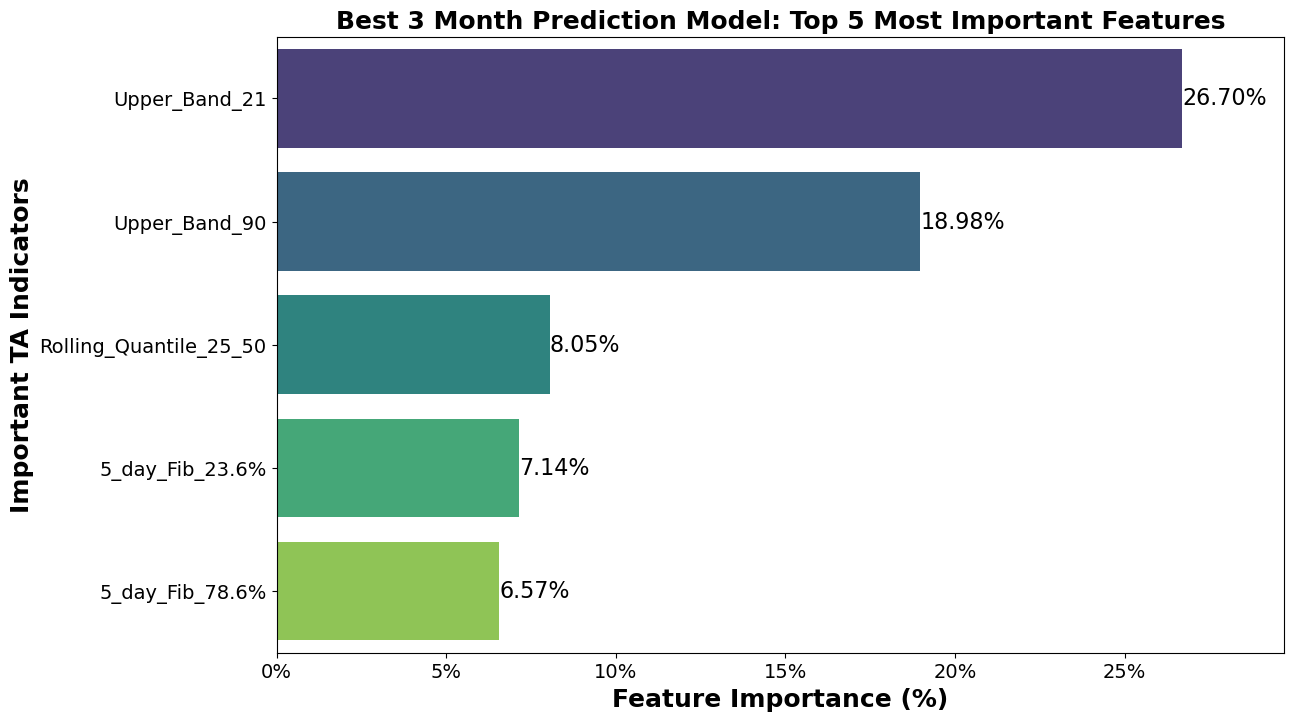

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_3_month_md_7[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_3_month_md_7[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 3 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


Mean Squared Error on unseen data: 11983.428659732108
Mean Absolute Error on unseen data: 26.83200744874819
Root Mean Squared Error on unseen data: 109.46884789624904
R-squared on unseen data: 0.8757257771770746
Median Absolute Error on unseen data: 9.406257629394531
Durbin-Watson Statistic on unseen data: 0.014586058250260934
MAPE on unseen data: 10.59%

In [103]:
# PCA for 3 month best prediction model

# Scale dataset to standardizeed (mean = 0, variance = 1)
from sklearn.preprocessing import StandardScaler

# Standardize the features before applying PCA
scaler = StandardScaler()
X_train_3_month_md_3_scaled = scaler.fit_transform(X_train_3_month_md_3)
X_test_3_month_md_3_scaled = scaler.transform(X_test_3_month_md_3)

In [104]:
# run PCA: keep enough componants to explain 99% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_3_month_md_3_scaled = imputer.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_scaled = imputer.transform(X_test_3_month_md_3_scaled)


# Apply PCA and keep enough components to explain 99% of variance
pca_99 = PCA(n_components=0.99)  # Retains 99% of the variance
X_train_3_month_md_3_99_pca = pca_99.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_99_pca= pca_99.transform(X_test_3_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 99% variance: ", pca_99.n_components_)


Number of components retained for 99% variance:  49


In [105]:
# Train XGBoost model using PCA-transformed data
# explain 99% of the variance
model_3_month_md_3_99_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)

# Train the model
model_3_month_md_3_99_pca.fit(X_train_3_month_md_3_99_pca, y_train_3_month_md_3)

# Predict on test data
y_pred_3_month_md_3_99_pca = model_3_month_md_3_99_pca.predict(X_test_3_month_md_3_99_pca)

# Calculate MSE
mse_test_3_month_md_3_99_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_99_pca)
print(f'Mean Squared Error after PCA: {mse_test_3_month_md_3_99_pca}')

Mean Squared Error after PCA: 8777.207566625053


In [106]:
# metrics and feature importance on unseen data
# explain 99% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_3_month_md_3_99_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_99_pca)
mae_3_month_md_3_99_pca = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_99_pca)
rmse_3_month_md_3_99_pca = np.sqrt(mse_3_month_md_3_99_pca)  # Root Mean Squared Error
r2_3_month_md_3_99_pca = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3_99_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3_99_pca}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3_99_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3_99_pca}')
print(f'R-squared on unseen data: {r2_3_month_md_3_99_pca}')

# Additional metrics
medae_3_month_md_3_99_pca = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_99_pca)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3_99_pca}')

dw_stat_3_month_md_3_99_pca = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3_99_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3_99_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3_99_pca = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3_99_pca) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3_99_pca:.2f}%')


Mean Squared Error on unseen data: 8777.207566625053
Mean Absolute Error on unseen data: 40.806804880687736
Root Mean Squared Error on unseen data: 93.6867523539217
R-squared on unseen data: 0.77139247658591
Median Absolute Error on unseen data: 15.19732666015625
Durbin-Watson Statistic on unseen data: 0.020281957780338564
MAPE on unseen data: 13.10%


In [107]:
# run PCA: keep enough componants to explain 95% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_3_month_md_3_scaled = imputer.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_scaled = imputer.transform(X_test_3_month_md_3_scaled)


# Apply PCA and keep enough components to explain 95% of variance
pca_95 = PCA(n_components=0.95)  # Retains 95% of the variance
X_train_3_month_md_3_95_pca = pca_95.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_95_pca= pca_95.transform(X_test_3_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 95% variance: ", pca_95.n_components_)


Number of components retained for 95% variance:  17


In [108]:
# Train XGBoost model using PCA-transformed data
# explain 95% of the variance
model_3_month_md_3_95_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)

# Train the model
model_3_month_md_3_95_pca.fit(X_train_3_month_md_3_95_pca, y_train_3_month_md_3)

# Predict on test data
y_pred_3_month_md_3_95_pca = model_3_month_md_3_95_pca.predict(X_test_3_month_md_3_95_pca)

# Calculate MSE
mse_test_3_month_md_3_95_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_95_pca)
print(f'Mean Squared Error after PCA: {mse_test_3_month_md_3_95_pca}')

Mean Squared Error after PCA: 9372.705823960192


In [109]:
# metrics and feature importance on unseen data
# explain 95% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_3_month_md_3_95_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_95_pca)
mae_3_month_md_3_95_pca = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_95_pca)
rmse_3_month_md_3_95_pca = np.sqrt(mse_3_month_md_3_95_pca)  # Root Mean Squared Error
r2_3_month_md_3_95_pca = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3_95_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3_95_pca}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3_95_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3_95_pca}')
print(f'R-squared on unseen data: {r2_3_month_md_3_95_pca}')

# Additional metrics
medae_3_month_md_3_95_pca = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_95_pca)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3_95_pca}')

dw_stat_3_month_md_3_95_pca = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3_95_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3_95_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3_95_pca = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3_95_pca) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3_95_pca:.2f}%')


Mean Squared Error on unseen data: 9372.705823960192
Mean Absolute Error on unseen data: 42.175179290691844
Root Mean Squared Error on unseen data: 96.81273585618884
R-squared on unseen data: 0.755882374907964
Median Absolute Error on unseen data: 15.336578369140625
Durbin-Watson Statistic on unseen data: 0.019022421643859647
MAPE on unseen data: 13.33%


In [110]:
# run PCA: keep enough componants to explain 90% of the variance
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# impute PCA X columns to median
imputer = SimpleImputer(strategy='median')
X_train_3_month_md_3_scaled = imputer.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_scaled = imputer.transform(X_test_3_month_md_3_scaled)


# Apply PCA and keep enough components to explain 90% of variance
pca_90 = PCA(n_components=0.90)  # Retains 90% of the variance
X_train_3_month_md_3_90_pca = pca_90.fit_transform(X_train_3_month_md_3_scaled)
X_test_3_month_md_3_90_pca= pca_90.transform(X_test_3_month_md_3_scaled)


# Number of components retained
print("Number of components retained for 90% variance: ", pca_90.n_components_)


Number of components retained for 90% variance:  10


In [111]:
# Train XGBoost model using PCA-transformed data
# explain 90% of the variance
model_3_month_md_3_90_pca = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    missing=np.nan
)

# Train the model
model_3_month_md_3_90_pca.fit(X_train_3_month_md_3_90_pca, y_train_3_month_md_3)

# Predict on test data
y_pred_3_month_md_3_90_pca = model_3_month_md_3_90_pca.predict(X_test_3_month_md_3_90_pca)

# Calculate MSE
mse_test_3_month_md_3_90_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_90_pca)
print(f'Mean Squared Error after PCA: {mse_test_3_month_md_3_90_pca}')

Mean Squared Error after PCA: 8659.268489153566


In [112]:
# metrics and feature importance on unseen data
# explain 90% of the variance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Calculate performance metrics on unseen test data
mse_3_month_md_3_90_pca = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3_90_pca)
mae_3_month_md_3_90_pca = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_90_pca)
rmse_3_month_md_3_90_pca = np.sqrt(mse_3_month_md_3_90_pca)  # Root Mean Squared Error
r2_3_month_md_3_90_pca = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3_90_pca)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3_90_pca}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3_90_pca}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3_90_pca}')
print(f'R-squared on unseen data: {r2_3_month_md_3_90_pca}')

# Additional metrics
medae_3_month_md_3_90_pca = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3_90_pca)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3_90_pca}')

dw_stat_3_month_md_3_90_pca = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3_90_pca)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3_90_pca}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3_90_pca = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3_90_pca) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3_90_pca:.2f}%')


Mean Squared Error on unseen data: 8659.268489153566
Mean Absolute Error on unseen data: 40.870499681779386
Root Mean Squared Error on unseen data: 93.05519055460348
R-squared on unseen data: 0.7744642690905125
Median Absolute Error on unseen data: 15.451101303100586
Durbin-Watson Statistic on unseen data: 0.020358031445916278
MAPE on unseen data: 13.08%


In [ ]:
# don't need this - delete

# might be useful but we don't need this
from collections import defaultdict
# maybe put all feature importances of best models together and find the top 5 most contributing features

# Combine feature importance values
feature_importance_dict = defaultdict(float)
feature_counts = defaultdict(int)  # Track how many lists each feature appears in

# All feature-importance lists
feature_lists = [sorted_features_1_month_md_3, sorted_features_1_week_md_3, sorted_features_3_month_md_3]

# Iterate through all feature-importance pairs and track occurrences
for feature_list in feature_lists:
    seen_in_this_list = set()  # Avoid double counting in the same list
    for feature, importance in feature_list:
        feature_importance_dict[feature] += importance
        seen_in_this_list.add(feature)
    for feature in seen_in_this_list:
        feature_counts[feature] += 1  # Count how many different lists include this feature

# Keep only features that appear in all three lists
filtered_features = {
    feature: importance
    for feature, importance in feature_importance_dict.items()
    if feature_counts[feature] == 3
}

# Sort features by importance in descending order
sorted_features = sorted(filtered_features.items(), key=lambda x: x[1], reverse=True)

# Print only features with at least 1% total importance
for feature, importance in sorted_features:
    if importance * 100 >= 1:
        print(f"{feature}: {importance * 100:.2f}%")

In [ ]:
# don't need this - delete

# don't think we need this
# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.05, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 4.5)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Top 5 Most Important Features Across All Three Timeframes", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()

best model: learning_rate = 0.01 and max_depth = 3

Best model metrics

most important metrics to visualize:

1. Root Mean Squared Error
2. R-squared
3. MAPE
4. Median Absolute Error



In [ ]:
# I don't thinik we need these, think about it but probably delete

# Root mean squared error graph
import matplotlib.pyplot as plt

# Define time horizons and RMSE values
time_horizons = ["1 Week", "1 Month", "3 Months"]
rmse_values = [rmse_1_week_md_7, rmse_1_month_md_7, rmse_3_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, rmse_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Different Prediction Timelines")
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# I don't thinik we need these, think about it but probably delete


# r squared graph
import matplotlib.pyplot as plt

# Define time horizons and R-squared values
time_horizons = ["1 Week", "1 Month", "3 Months"]
r_squared_values = [r2_1_week_md_7, r2_1_month_md_7, r2_3_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, r_squared_values, marker='o', linestyle='-', color='g', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("R-squared")
plt.title("R-squared Across Different Prediction Timelines")
plt.ylim(0.85, 0.9)  # Setting limits for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# I don't thinik we need these, think about it but probably delete


# MAPE graph
import matplotlib.pyplot as plt

# Define time horizons and MAPE values
time_horizons = ["1 Week", "1 Month", "3 Months"]
mape_values = [mape_1_week_md_7, mape_1_month_md_7, mape_3_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, mape_values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Error (MAPE) Over Different Prediction Horizons")
plt.ylim(0, 15)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# I don't thinik we need these, think about it but probably delete


# Median Absolute Error
import matplotlib.pyplot as plt

# Define time horizons and Median Absolute Error values
time_horizons = ["1 Week", "1 Month", "3 Months"]
medae_values = [medae_1_week_md_7, medae_1_month_md_7, medae_3_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, medae_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Median Absolute Error")
plt.title("Median Absolute Error Over Different Prediction Horizons")
plt.ylim(0, 15)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


1 week model to use:

* stock_data_test_1_week_md_3
* higher predictive power (99% PCA): y_pred_1_week_md_3_99_pca
* more generalized (90% PCA): y_pred_1_week_md_3_90_pca
* best: non pcA y_pred_1_week_md_3

1 month model to use:

* stock_data_test_1_month_md_3
* higher predictive power: y_pred_1_month_md_3
* more generalized: y_pred_1_month_md_3_95_pca
* y_pred_1_month_md_3_99_pca

3 month model to use:

* stock_data_test_3_month_md_3
* higher predictive power: y_pred_3_month_md_3_99_pca
* more generalized: y_pred_3_month_md_3_95_pca
* y_pred_3_month_md_3

In [113]:
# Creating dataframes to test prediction models further


stock_data_1_week['Date'] = pd.to_datetime(stock_data_1_week['Date'], errors='coerce')
stock_data_1_month['Date'] = pd.to_datetime(stock_data_1_month['Date'], errors='coerce')
stock_data_3_month['Date'] = pd.to_datetime(stock_data_3_month['Date'], errors='coerce')

stock_data_1_week_shift = stock_data_1_week.copy()
stock_data_1_month_shift = stock_data_1_month.copy()
stock_data_3_month_shift = stock_data_3_month.copy()


columns_to_keep = ['Symbol', 'Date', 'Close']
stock_data_1_week_shift.drop(columns = [col for col in stock_data_1_week_shift.columns if col not in columns_to_keep], inplace=True)
stock_data_1_month_shift.drop(columns = [col for col in stock_data_1_month_shift.columns if col not in columns_to_keep], inplace=True)
stock_data_3_month_shift.drop(columns = [col for col in stock_data_3_month_shift.columns if col not in columns_to_keep], inplace=True)


stock_data_1_week_shift = stock_data_1_week_shift[stock_data_1_week_shift['Date'].isin(stock_data_test_1_week_md_3['Date'])]
stock_data_1_week_shift = stock_data_1_week_shift.reset_index(drop=True)

stock_data_1_month_shift = stock_data_1_month_shift[stock_data_1_month_shift['Date'].isin(stock_data_test_1_month_md_3['Date'])]
stock_data_1_month_shift = stock_data_1_month_shift.reset_index(drop=True)

stock_data_3_month_shift = stock_data_3_month_shift[stock_data_3_month_shift['Date'].isin(stock_data_test_3_month_md_3['Date'])]
stock_data_3_month_shift = stock_data_3_month_shift.reset_index(drop=True)

predicted_values_1_week = pd.DataFrame(y_pred_1_week_md_3)
predicted_values_1_month = pd.DataFrame(y_pred_1_month_md_3_95_pca)
predicted_values_3_month = pd.DataFrame(y_pred_3_month_md_3_95_pca)

one_week_predictions_df = pd.concat([stock_data_1_week_shift, predicted_values_1_week], axis=1)
one_month_predictions_df = pd.concat([stock_data_1_month_shift, predicted_values_1_month], axis=1)
three_month_predictions_df = pd.concat([stock_data_3_month_shift, predicted_values_3_month], axis=1)

predictions_df = [one_week_predictions_df, one_month_predictions_df, three_month_predictions_df]

for i in range(len(predictions_df)):
    predictions_df[i] = predictions_df[i].rename(columns={0: 'Predicted Price',
                                                         'Close': 'Actual Price',
                                                         'Close_Target': 'Starting Price'},  inplace=True)

# Group by Symbol and shift prices within each Symbol group
one_week_predictions_df['Starting Price'] = one_week_predictions_df.groupby('Symbol')['Actual Price'].shift(5)
one_week_predictions_df['Predicted Price For Today'] = one_week_predictions_df.groupby('Symbol')['Predicted Price'].shift(5)
one_week_predictions_df = one_week_predictions_df.dropna(subset=['Predicted Price For Today', 'Starting Price']).reset_index(drop=True)

one_month_predictions_df['Starting Price'] = one_month_predictions_df.groupby('Symbol')['Actual Price'].shift(20)
one_month_predictions_df['Predicted Price For Today'] = one_month_predictions_df.groupby('Symbol')['Predicted Price'].shift(20)
one_month_predictions_df = one_month_predictions_df.dropna(subset=['Predicted Price For Today', 'Starting Price']).reset_index(drop=True)

three_month_predictions_df['Starting Price'] = three_month_predictions_df.groupby('Symbol')['Actual Price'].shift(60)
three_month_predictions_df['Predicted Price For Today'] = three_month_predictions_df.groupby('Symbol')['Predicted Price'].shift(60)
three_month_predictions_df = three_month_predictions_df.dropna(subset=['Predicted Price For Today', 'Starting Price']).reset_index(drop=True)

one_week_predictions_df.head()

,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741


In [135]:
one_week_predictions_df['Date'] = pd.to_datetime(one_week_predictions_df['Date'], errors='coerce')
one_month_predictions_df['Date'] = pd.to_datetime(one_month_predictions_df['Date'], errors='coerce')
three_month_predictions_df['Date'] = pd.to_datetime(three_month_predictions_df['Date'], errors='coerce')
# full_date_range = pd.date_range(
#     start = one_week_predictions_df['Date'].min(), end = one_week_predictions_df['Date'].max(), freq = 'D')
# trading_days = set(one_week_predictions_df['Date'])
# missing_days = [date for date in full_date_range if date not in trading_days]
# total_missing_days = len(missing_days)
# total_trading_weeks = (one_week_predictions_df['Date'].max() - one_week_predictions_df['Date'].min()).days / 7
# average_missing_days_per_week = total_missing_days / total_trading_weeks
avg_trading_days_per_calendar_year = 252
non_trading_days_per_year = 365 - 252
avg_non_trading_days_per_week = (non_trading_days_per_year / (365)) * 7
avg_non_trading_days_per_month = non_trading_days_per_year / 12
avg_non_trading_days_per_3_month = non_trading_days_per_year / 4
avg_trading_days_per_calendar_day = (avg_trading_days_per_calendar_year / 365)
avg_trading_days_1_week = avg_trading_days_per_calendar_day * 7
avg_trading_days_1_month = avg_trading_days_per_calendar_day * (365/12)
avg_trading_days_3_month = avg_trading_days_per_calendar_day * (365/4)
avg_days_holding_trade_1_week = avg_trading_days_1_week + avg_non_trading_days_per_week
avg_days_holding_trade_1_month = avg_trading_days_1_month + avg_non_trading_days_per_month
avg_days_holding_trade_3_month = avg_trading_days_3_month + avg_non_trading_days_per_3_month
# print(f'Total Missing (non-trading) days: {total_missing_days}')
# print(f'Average missing days per week: {average_missing_days_per_week}')
# print(f'Average missing days to add to 20 trading-day prediction: {average_missing_days_per_week*4}')
# print(f'Average missing days to add to 60 trading-day prediction: {average_missing_days_per_week*12}')
print(f'Average length holding 1 week trade: {avg_days_holding_trade_1_week}')
print(f'Average length holding 1 month trade: {avg_days_holding_trade_1_month}')
print(f'Average length holding 3 month trade: {avg_days_holding_trade_3_month}')

Average length holding 1 week trade: 7.0
Average length holding 1 month trade: 30.41666666666667
Average length holding 3 month trade: 91.25


In [136]:
def calculate_days_held(prediction_timeframe, avg_holding_days, index, data_series):
    if index < prediction_timeframe:
        return avg_holding_days
    return (data_series.iloc[index] - data_series.iloc[index - prediction_timeframe]).days


# Sort & Apply within the group
one_week_predictions_df = one_week_predictions_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)
one_month_predictions_df = one_month_predictions_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)
three_month_predictions_df = three_month_predictions_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)

# Apply function using transform() instead of apply()
one_week_predictions_df['Length of Holding Trade (days)'] = one_week_predictions_df.groupby('Symbol')['Date'].transform(
    lambda group: group.reset_index(drop=True).index.to_series().apply(
        lambda idx: calculate_days_held(5, avg_days_holding_trade_1_week, idx, group)
    )
)

one_month_predictions_df['Length of Holding Trade (days)'] = one_month_predictions_df.groupby('Symbol')['Date'].transform(
    lambda group: group.reset_index(drop=True).index.to_series().apply(
        lambda idx: calculate_days_held(20, avg_days_holding_trade_1_month, idx, group)
    )
)

three_month_predictions_df['Length of Holding Trade (days)'] = three_month_predictions_df.groupby('Symbol')['Date'].transform(
    lambda group: group.reset_index(drop=True).index.to_series().apply(
        lambda idx: calculate_days_held(60, avg_days_holding_trade_3_month, idx, group)
    )
)


In [137]:
one_week_predictions_df[2543:2550]

,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD,Abs_Error,Rolling_MAE,Normalized Abs Error,Day of the Week
2543,2025-02-18,BAC,46.529999,46.558636,46.669998,46.928860,NaN,-0.398861,0.711011,0.398861,0.578721,-0.252963,Tuesday
2544,2025-02-19,BAC,46.009998,46.141487,46.790001,46.577152,NaN,-0.567154,0.709816,0.567154,0.566825,0.000463,Wednesday
2545,2023-02-08,COST,486.375641,496.006958,499.118835,497.832153,NaN,-11.456512,0.726891,11.456512,0.598702,14.937325,Wednesday
2546,2023-02-09,COST,483.305695,490.518707,505.316681,515.909973,NaN,-32.604279,3.032581,32.604279,1.325740,10.314166,Thursday
2547,2023-02-10,COST,482.687836,489.991943,496.985291,499.917908,NaN,-17.230072,8.726171,17.230072,3.470959,1.576764,Friday
2548,2023-02-13,COST,488.924316,491.010040,497.748047,497.051727,NaN,-8.127411,9.409333,8.127411,4.618111,0.372959,Monday
2549,2023-02-14,COST,485.806030,491.025299,498.655518,497.286987,NaN,-11.480957,9.402345,11.480957,5.130026,0.675462,Tuesday


In [126]:
# now we have our dataframe with the actual price, starting price, and predicted price

# avg magnitude of preditions from starting price and avg of magnitude of actual from starting price
predictions_df_dict = {
    "One Week Model": one_week_predictions_df,
    "One Month Model": one_month_predictions_df,
    "Three Month Model": three_month_predictions_df
}

total_actual_diff = {}
total_pred_diff = {}
actual_pred_diff = {}

for key, df in predictions_df_dict.items():
    total_actual_diff[key] = 0
    total_pred_diff[key] = 0 
    actual_pred_diff[key] = 0
    for i, row in df.iterrows():
        total_actual_diff[key] += ((abs(row['Actual Price'] - row['Starting Price'])) / row['Starting Price']) * 100
        total_pred_diff[key] += ((abs(row['Predicted Price For Today'] - row['Actual Price'])) / row['Starting Price']) * 100
        actual_pred_diff[key] += ((abs(row['Predicted Price For Today'] - row['Actual Price'])) / row['Actual Price']) * 100

# Compute averages by dividing by the number of rows in each DataFrame
average_actual_diff = {key: (total_actual_diff[key] / len(df)) if len(df) > 0 else 0 for key, df in predictions_df_dict.items()}
average_pred_diff = {key: (total_pred_diff[key] / len(df)) if len(df) > 0 else 0 for key, df in predictions_df_dict.items()}
avg_pred_actual_diff = {key: (actual_pred_diff[key] / len(df)) if len(df) > 0 else 0 for key, df in predictions_df_dict.items()}


# Print results
for key in predictions_df_dict.keys():
    print(f"{key} - Average Percent Magnitude from Starting Price to Actual Price: {average_actual_diff[key]:.2f}%")
    print(f"{key} - Average Magnitude from Starting Price to Predicted Price: {average_pred_diff[key]:.2f}%")
    print(f"{key} - Average Magnitude from Actual Price to Predicted Price: {avg_pred_actual_diff[key]:.2f}%\n")


One Week Model - Average Percent Magnitude from Starting Price to Actual Price: 2.89%
One Week Model - Average Magnitude from Starting Price to Predicted Price: 4.87%
One Week Model - Average Magnitude from Actual Price to Predicted Price: 4.80%

One Month Model - Average Percent Magnitude from Starting Price to Actual Price: 6.09%
One Month Model - Average Magnitude from Starting Price to Predicted Price: 9.78%
One Month Model - Average Magnitude from Actual Price to Predicted Price: 9.30%

Three Month Model - Average Percent Magnitude from Starting Price to Actual Price: 12.12%
Three Month Model - Average Magnitude from Starting Price to Predicted Price: 15.03%
Three Month Model - Average Magnitude from Actual Price to Predicted Price: 13.05%



In [127]:
# Not sure if i need this or if it's even calculating correctly
# okay nevermind i was calculating it wrong and put my 1 week prediction model
# instead of df, might be good idk

predictions_df_dict = {
    "One Week Prediction Model": one_week_predictions_df,
    "One Month Prediction Model": one_month_predictions_df,
    "Three Month Prediction Model": three_month_predictions_df
}

total_pred_up = {}
total_pred_down = {}
total_actual_increase = {}
total_actual_decrease = {}
total_pred_wrong_direction = {}
correct_pred_up = {}
correct_pred_down = {}
correct_pred_up_over_estimate = {}
correct_pred_up_under_estimate = {}
correct_pred_down_over_estimate = {}
correct_pred_down_under_estimate = {}
total_over_estimate_bull_mag_percent = {}
total_under_estimate_bull_mag_percent = {}
total_over_estimate_bear_mag_percent = {}
total_under_estimate_bear_mag_percent = {}

for key, df in predictions_df_dict.items():
    total_pred_up[key] = 0
    total_pred_down[key] = 0
    total_actual_increase[key] = 0
    total_actual_decrease[key] = 0
    total_pred_wrong_direction[key] = 0
    correct_pred_up[key] = 0
    correct_pred_down[key] = 0
    correct_pred_up_over_estimate[key] = 0
    correct_pred_up_under_estimate[key] = 0
    correct_pred_down_over_estimate[key] = 0
    correct_pred_down_under_estimate[key] = 0
    total_over_estimate_bull_mag_percent[key] = 0
    total_under_estimate_bull_mag_percent[key] = 0
    total_over_estimate_bear_mag_percent[key] = 0
    total_under_estimate_bear_mag_percent[key] = 0
    for i, row in df.iterrows():
        pred_change = row['Predicted Price For Today'] - row['Starting Price']
        actual_change = row['Actual Price'] - row['Starting Price']
        if pred_change > 0:
            total_pred_up[key] += 1
        elif pred_change < 0:
            total_pred_down[key] += 1
    
        if actual_change > 0:
            total_actual_increase[key] += 1
        elif actual_change < 0:
            total_actual_decrease[key] += 1
    
        if pred_change > 0 and actual_change > 0 and pred_change > actual_change:
            correct_pred_up[key] += 1
            correct_pred_up_over_estimate[key] += 1
            total_over_estimate_bull_mag_percent[key] += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
        elif pred_change > 0 and actual_change > 0 and pred_change < actual_change:
            correct_pred_up[key] += 1
            correct_pred_up_under_estimate[key] += 1
            total_under_estimate_bull_mag_percent[key] += (abs(pred_change - actual_change) / row['Actual Price']) * 100
        
        elif pred_change < 0  and actual_change < 0 and abs(pred_change) > abs(actual_change):
            correct_pred_down[key] += 1
            correct_pred_down_over_estimate[key] += 1
            total_over_estimate_bear_mag_percent[key] += (abs(pred_change - actual_change) / row['Actual Price']) * 100
        
        elif pred_change < 0  and actual_change < 0 and abs(pred_change) < abs(actual_change):
            correct_pred_down[key] += 1
            correct_pred_down_under_estimate[key] += 1
            total_under_estimate_bear_mag_percent[key] += (abs(pred_change - actual_change) / row['Actual Price']) * 100
        
        if pred_change > 0  and actual_change < 0:
            total_pred_wrong_direction[key] += 1
        elif pred_change < 0  and actual_change > 0:
            total_pred_wrong_direction[key] += 1

correct_price_increase = {key: ((correct_pred_up[key] / total_pred_up[key]
                                ) * 100) if total_pred_up[key] else 0 for key, df in predictions_df_dict.items()}

correct_price_decrease = {key: ((correct_pred_down[key] / total_pred_down[key]
                                ) * 100) if total_pred_down[key] else 0 for key, df in predictions_df_dict.items()}

pred_wrong_direction = {key: ((total_pred_wrong_direction[key] / (
    total_pred_up[key] + total_pred_down[key])) * 100) if (
    total_pred_up[key] + total_pred_down[key]) else 0 for key, df in predictions_df_dict.items()}

over_estimate_correct_bull_pred = {key: ((correct_pred_up_over_estimate[key] / correct_pred_up[key]
                                ) * 100) if correct_pred_up[key] else 0 for key, df in predictions_df_dict.items()}

under_estimate_correct_bull_pred = {key: ((correct_pred_up_under_estimate[key] / correct_pred_up[key]
                                ) * 100) if correct_pred_up[key] else 0 for key, df in predictions_df_dict.items()}

over_estimate_correct_bear_pred = {key: ((correct_pred_down_over_estimate[key] / correct_pred_down[key]
                                ) * 100) if correct_pred_down[key] else 0 for key, df in predictions_df_dict.items()}

under_estimate_correct_bear_pred = {key: ((correct_pred_down_under_estimate[key] / correct_pred_down[key]
                                ) * 100) if correct_pred_down[key] else 0 for key, df in predictions_df_dict.items()}

avg_bull_over_estimate_mag_percent = {key: (total_over_estimate_bull_mag_percent[key] / correct_pred_up_over_estimate[key]
                                ) if correct_pred_up_over_estimate[key] else 0 for key, df in predictions_df_dict.items()}

avg_bull_under_estimate_mag_percent = {key: (total_under_estimate_bull_mag_percent[key] / correct_pred_up_under_estimate[key]
                                ) if correct_pred_up_under_estimate[key] else 0 for key, df in predictions_df_dict.items()}

avg_bear_over_estimate_mag_percent = {key: (total_over_estimate_bear_mag_percent[key] / correct_pred_down_over_estimate[key]
                                ) if correct_pred_down_over_estimate[key] else 0 for key, df in predictions_df_dict.items()}

avg_bear_under_estimate_mag_percent = {key: (total_under_estimate_bear_mag_percent[key] / correct_pred_down_under_estimate[key]
                                ) if correct_pred_down_under_estimate[key] else 0 for key, df in predictions_df_dict.items()}

# Print results
for key in predictions_df_dict.keys():
    print(f'{key} - Total correct bullish predictions: {correct_pred_up[key]}')
    print(f'{key} - Total correct bearish predictions: {correct_pred_down[key]}\n')
    print(f'{key} - Correct Bullish Predictions: {correct_price_increase[key]:.2f}%')
    print(f'{key} - Correct Bearish Predictions: {correct_price_decrease[key]:.2f}%\n')
    print(f'{key} - Missed Direction: {pred_wrong_direction[key]:.2f}%\n')
    print(f'{key} - Percentage of Overestimated Correct Bullish Predictions: {over_estimate_correct_bull_pred[key]:.2f}%')
    print(f'{key} - Average magnitude of Overestimated Correct Bullish Predictions: {avg_bull_over_estimate_mag_percent[key]:.2f}%\n')
    print(f'{key} - Percentage of Underestimated Correct Bullish Predictions: {under_estimate_correct_bull_pred[key]:.2f}%')
    print(f'{key} - Average magnitude of Underestimated Correct Bullish Predictions: {avg_bull_under_estimate_mag_percent[key]:.2f}%\n')
    print(f'{key} - Percentage of Overestimated Correct Bearish Predictions: {over_estimate_correct_bear_pred[key]:.2f}%')
    print(f'{key} - Average magnitude of Overestimated Correct Bearish Predictions: {avg_bear_over_estimate_mag_percent[key]:.2f}%\n')
    print(f'{key} - Percentage of Underestimated Correct Bearish Predictions: {under_estimate_correct_bear_pred[key]:.2f}%')
    print(f'{key} - Average magnitude of Underestimated Correct Bearish Predictions: {avg_bear_under_estimate_mag_percent[key]:.2f}%\n')


One Week Prediction Model - Total correct bullish predictions: 3659
One Week Prediction Model - Total correct bearish predictions: 2676

One Week Prediction Model - Correct Bullish Predictions: 56.78%
One Week Prediction Model - Correct Bearish Predictions: 42.61%

One Week Prediction Model - Missed Direction: 50.12%

One Week Prediction Model - Percentage of Overestimated Correct Bullish Predictions: 20.36%
One Week Prediction Model - Average magnitude of Overestimated Correct Bullish Predictions: 0.84%

One Week Prediction Model - Percentage of Underestimated Correct Bullish Predictions: 79.64%
One Week Prediction Model - Average magnitude of Underestimated Correct Bullish Predictions: 2.62%

One Week Prediction Model - Percentage of Overestimated Correct Bearish Predictions: 34.94%
One Week Prediction Model - Average magnitude of Overestimated Correct Bearish Predictions: 10.17%

One Week Prediction Model - Percentage of Underestimated Correct Bearish Predictions: 65.06%
One Week Pr

In [128]:
# Calculation for Error
one_week_predictions_df['Error'] = one_week_predictions_df['Actual Price'] - one_week_predictions_df['Predicted Price For Today']
one_month_predictions_df['Error'] = one_month_predictions_df['Actual Price'] - one_month_predictions_df['Predicted Price For Today']
three_month_predictions_df['Error'] = three_month_predictions_df['Actual Price'] - three_month_predictions_df['Predicted Price For Today']


In [129]:
one_week_predictions_df['Rolling_STD'] = (
    one_week_predictions_df['Error'].shift(1).rolling(window=15).std()
)
one_month_predictions_df['Rolling_STD'] = (
    one_month_predictions_df['Error'].shift(1).rolling(window=45).std()
)
three_month_predictions_df['Rolling_STD'] = (
    three_month_predictions_df['Error'].shift(1).rolling(window=120).std()
)

one_week_predictions_df.head()

,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655,7.0,8.005249,NaN
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488,7.0,0.092499,NaN
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637,7.0,-0.172333,NaN
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792,7.0,2.686172,NaN
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741,7.0,1.851715,NaN


In [130]:
# we will also add rolling absolute error

one_week_predictions_df['Abs_Error'] = abs(one_week_predictions_df['Error'])
one_week_predictions_df['Rolling_MAE'] = one_week_predictions_df['Abs_Error'].shift(1).rolling(
    window=15).mean()

one_month_predictions_df['Abs_Error'] = abs(one_month_predictions_df['Error'])
one_month_predictions_df['Rolling_MAE'] = one_month_predictions_df['Abs_Error'].shift(1).rolling(
    window=45).mean()

three_month_predictions_df['Abs_Error'] = abs(three_month_predictions_df['Error'])
three_month_predictions_df['Rolling_MAE'] = three_month_predictions_df['Abs_Error'].shift(1).rolling(
    window=120).mean()
one_week_predictions_df.head()

,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD,Abs_Error,Rolling_MAE
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655,7.0,8.005249,NaN,8.005249,NaN
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488,7.0,0.092499,NaN,0.092499,NaN
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637,7.0,-0.172333,NaN,0.172333,NaN
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792,7.0,2.686172,NaN,2.686172,NaN
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741,7.0,1.851715,NaN,1.851715,NaN


In [131]:
# cool stats, can't use it for trading model because it uses future data
# mean error
# we'll do one for up scenarios, one for down scenarios, then one overall

predictions_df_dict = {
    "One Week Prediction Model": one_week_predictions_df,
    "One Month Prediction Model": one_month_predictions_df,
    "Three Month Prediction Model": three_month_predictions_df
}

for name, df in predictions_df_dict.items():
    bullish_count = 0
    bearish_count = 0
    bullish_sum = 0
    bearish_sum = 0
    for i, row in df.iterrows():
        actual_bull = row['Actual Price'] > row['Starting Price']
        actual_bear = row['Actual Price'] < row['Starting Price']
        predicted_bull = row['Predicted Price For Today'] > row['Starting Price']
        predicted_bear = row['Predicted Price For Today'] < row['Starting Price']
        if actual_bull and predicted_bull:
            bullish_sum += row['Actual Price'] - row['Predicted Price For Today']
            bullish_count += 1
        elif actual_bear and predicted_bear:
            bearish_sum += row['Actual Price'] - row['Predicted Price For Today']
            bearish_count +=1
    
    bullish_mean_error = (bullish_sum / bullish_count)
    bearish_mean_error = (bearish_sum / bearish_count)
    bullish_mean_error_percent = (bullish_mean_error / df['Starting Price'].mean()) * 100
    bearish_mean_error_percent = (bearish_mean_error / df['Starting Price'].mean()) * 100
    print(f'{name}')
    print(f'Bullish Mean Error: {bullish_mean_error_percent:.2f}%')
    print(f'Bearish Mean Error: {bearish_mean_error_percent:.2f}%\n')
    # this is good stuff
    # i think this is slightly better than the overestimation/underestimation calculation i did above

One Week Prediction Model
Bullish Mean Error: 1.32%
Bearish Mean Error: 10.05%

One Month Prediction Model
Bullish Mean Error: 2.84%
Bearish Mean Error: 12.00%

Three Month Prediction Model
Bullish Mean Error: 5.19%
Bearish Mean Error: 5.33%



In [132]:
predictions_df_dict = {
    "One Week Prediction Model": one_week_predictions_df,
    "One Month Prediction Model": one_month_predictions_df,
    "Three Month Prediction Model": three_month_predictions_df
}

for name, df in predictions_df_dict.items():
    # Normalize using Rolling Mean Absolute Error (Rolling_MAE) and Rolling Standard Deviation (Rolling_STD)
    df['Normalized Abs Error'] = (df['Abs_Error'] - df['Rolling_MAE']) / df['Rolling_STD']

one_week_predictions_df.head()

,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD,Abs_Error,Rolling_MAE,Normalized Abs Error
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655,7.0,8.005249,NaN,8.005249,NaN,NaN
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488,7.0,0.092499,NaN,0.092499,NaN,NaN
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637,7.0,-0.172333,NaN,0.172333,NaN,NaN
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792,7.0,2.686172,NaN,2.686172,NaN,NaN
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741,7.0,1.851715,NaN,1.851715,NaN,NaN


In [133]:
# we edited this so that it can be used and uses no future data
# can't use this and we already got the stats above for avg 
# bullish and bearish mean error, delete

# interesting info but it leaks future data into our simulation so we can't use it

# Initialize dictionaries to store per-symbol errors
predictions_df_dict = {
    "One Week Prediction Model": one_week_predictions_df,
    "One Month Prediction Model": one_month_predictions_df,
    "Three Month Prediction Model": three_month_predictions_df
}

# Function to calculate bullish and bearish mean errors
def calculate_mean_error(df):
    bullish_errors = {}
    bearish_errors = {}
    
    df['Avg_Past_Starting_Price'] = df.groupby('Symbol')['Starting Price'].expanding().mean().shift(1)

    # Group by Symbol
    grouped = df.groupby('Symbol')

    # Iterate over each stock symbol group
    for symbol, group in grouped:
        bullish_count = 0
        bearish_count = 0
        bullish_sum = 0
        bearish_sum = 0
        
        for i, row in group.iterrows():
            actual_bull = row['Actual Price'] > row['Starting Price']
            actual_bear = row['Actual Price'] < row['Starting Price']
            predicted_bull = row['Predicted Price For Today'] > row['Starting Price']
            predicted_bear = row['Predicted Price For Today'] < row['Starting Price']
            
            if actual_bull and predicted_bull:
                bullish_sum += row['Actual Price'] - row['Predicted Price For Today']
                bullish_count += 1
            elif actual_bear and predicted_bear:
                bearish_sum += row['Actual Price'] - row['Predicted Price For Today']
                bearish_count += 1

        # Avoid division by zero
        bullish_mean_error = (bullish_sum / bullish_count) if bullish_count > 0 else 0
        bearish_mean_error = (bearish_sum / bearish_count) if bearish_count > 0 else 0
        
        # Convert to percentage of average starting price for the symbol
 
        avg_past_starting_price = group['Avg_Past_Starting_Price'].dropna().iloc[-1] if not group['Avg_Past_Starting_Price'].dropna().empty else np.nan

        bullish_mean_error_percent = (bullish_mean_error / avg_past_starting_price) if avg_past_starting_price > 0 else 0
        bearish_mean_error_percent = (bearish_mean_error / avg_past_starting_price) if avg_past_starting_price > 0 else 0
        
        # Store in dictionaries
        bullish_errors[symbol] = bullish_mean_error_percent
        bearish_errors[symbol] = bearish_mean_error_percent

    # Add the calculated mean errors to the dataframe
    df['Bullish Mean Error'] = df['Symbol'].map(bullish_errors)
    df['Bearish Mean Error'] = df['Symbol'].map(bearish_errors)
    
    return df

# Apply the function to each dataframe in the dictionary
for model_name, df in predictions_df_dict.items():
    df.fillna(0, inplace=True) 

one_week_predictions_df.head()


,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD,Abs_Error,Rolling_MAE,Normalized Abs Error
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655,7.0,8.005249,0.0,8.005249,0.0,0.0
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488,7.0,0.092499,0.0,0.092499,0.0,0.0
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637,7.0,-0.172333,0.0,0.172333,0.0,0.0
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792,7.0,2.686172,0.0,2.686172,0.0,0.0
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741,7.0,1.851715,0.0,1.851715,0.0,0.0


In [134]:
# get day of the week
import pandas as pd

predictions_df_dict = {
    "One Week Prediction Model": one_week_predictions_df,
    "One Month Prediction Model": one_month_predictions_df,
    "Three Month Prediction Model": three_month_predictions_df
}

for name, df in predictions_df_dict.items():
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get the day of the week as a string (e.g., Monday, Tuesday, etc.)
    df['Day of the Week'] = df['Date'].dt.day_name()

# Checking the result for the one week predictions
one_week_predictions_df.head()


,Date,Symbol,Actual Price,Predicted Price,Starting Price,Predicted Price For Today,Length of Holding Trade (days),Error,Rolling_STD,Abs_Error,Rolling_MAE,Normalized Abs Error,Day of the Week
0,2023-02-08,AAPL,150.173904,148.963974,143.758530,142.168655,7.0,8.005249,0.0,8.005249,0.0,0.0,Wednesday
1,2023-02-09,AAPL,149.135986,148.722061,149.086563,149.043488,7.0,0.092499,0.0,0.092499,0.0,0.0,Thursday
2,2023-02-10,AAPL,149.502304,148.592239,152.724274,149.674637,7.0,-0.172333,0.0,0.172333,0.0,0.0,Friday
3,2023-02-13,AAPL,152.313965,149.846771,149.986099,149.627792,7.0,2.686172,0.0,2.686172,0.0,0.0,Monday
4,2023-02-14,AAPL,151.670456,149.632904,152.872559,149.818741,7.0,1.851715,0.0,1.851715,0.0,0.0,Tuesday


## bullish mean error hedge
* positive: stock is likely to out perform bullish predictiono
* positive: increase size by bullish % or do nothing, or make position smaller to be safe
* negative: stock might underperform or not go up as much as expected
* negative: take % bullish error out of long position and short stock 

### bearish mean error hedge
* positive: price might not fall as expected
* positive: take % bearish error out of short and go long
* negative: stock could fall more than expected
* negative: do nothing, add bearish % to your position and short  more, or cut % in half and go long, or make positiono smaller

### Long: error hedge
* positive: stock has underperformed compared to expectatioons
* positive: short stock by some % of positiono
* negative: stock has outperformed expectations
* negative: do nothing, add to position, or decrease poosition size to protect profits while still benefitting from upwards movement

### Short: error hedge
* Positive: stock will be more resiliant/rise more than expected
* positive: go long by some % to limit loss
* negative: stock has fallen more than expected
* negative: do nothing, increase short positiono, or cut short poosition to prootect profit while benefitting from strong move

### Long: Error std. dev percent
* High: high degree of uncertainty in stock movement
* high: hedge with some % short
* low: stock is more stable
* low: do nothing, or add to position

### Short: Error std. dev percent
* High: high degree of uncertainty in stock movement
* high: hedge with some % long
* low: stock is more stable
* low: do nothing, or add to position

### Normalized error std dev percent
* instead of using error std dev percent, i normalized it from 0 to 1
* highest i will hedge is 50% if stock has std dev percent of 1
* if normalized std dev percent is 0.1, i will hedge my position 0.5%


#### Scenarios and rules
* if normalized < df['Normalized Error'].quantile(0.25)
* * no hedge for normalized error
 
* if normalized > df['Normalized Error'].quantile(0.25)
* * hedge = 1/2 normalized error
 
* if going long and bullish mean error negative
* * take bullish mean error % out of long and go short with it
 
* if going short and bearish mean error positive
* * take earish mean error % out of long and go short 

In [138]:
# this one the best onee so far
# RUNNING THIS ONE UPDATE 02/23/2025
# update 2 with leverage

# Trading simulation with no hedging
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
import numpy as np
import math
overall_results = []


# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_predictions_df.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0
    percent_gain = profit_loss / 100000
    
    trade_cost_history = []
    skip_iterations = 0
    
    for i, row in group.iterrows():
        num_trades_per_cycle = 5
        portfolio_loss_prevention = 0.5
        portfolio_trade_percent = 0.05
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price For Today']
        trade_date = row['Date']
        # length_holding_trade = row['Length of Holding Trade (days)']
        length_holding_trade = 7
        

        bullish_pred = predicted_price > starting_price
        actual_bull = actual_price > starting_price
        bearish_pred = predicted_price < starting_price
        actual_bear = actual_price < starting_price
        if skip_iterations > 0:
            skip_iterations -= 1
            continue
               
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05
        
        trade_size = 5000
        trade_fee = 0.0025
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        stock_borrow_daily_fee = stock_borrow_fee_percent / total_days_one_year
        starting_trade_cost = 0
        num_iteration_skips = 0
        leverage = 1
        margin_rate = 0.12
        margin_daily_rate = margin_rate / total_days_one_year
        
        
        if bullish_pred:
            bullish_trade_count += 1
            bull_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bull_starting_trade_cost = (bull_share_amount * starting_price)
            bull_start_trade_fee = bull_starting_trade_cost * trade_fee
            
            if leverage > 1:
                # Leverage
                trading_account -= leverage * (bull_starting_trade_cost + bull_start_trade_fee)
                bull_actual_trade_sell = bull_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                trading_account += leverage * (bull_actual_trade_sell - bull_actual_trade_fee)
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_start_trade_fee))
                bull_margin_fee = margin_daily_rate*length_holding_trade*(
                    bull_actual_trade_sell*leverage - bull_actual_trade_sell)
                profit_loss += (leverage * bullish_profit) - (bull_margin_fee)

                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
            else:
                # No Leverage
                trading_account -= (bull_starting_trade_cost + bull_start_trade_fee)
                bull_actual_trade_sell = bull_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_start_trade_fee))
                profit_loss += bullish_profit
            
                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

        elif bearish_pred:
            bearish_trade_count += 1
            bear_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bear_starting_short_trade_value = (bear_share_amount * starting_price)
            bear_start_trade_fee = bear_starting_short_trade_value * trade_fee
            bear_start_total_trade = (bear_starting_short_trade_value - bear_start_trade_fee)

            if leverage > 1:
                trading_account += leverage * bear_start_total_trade
                bear_actual_short_trade_value = (bear_share_amount * actual_price)
                bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
                stock_borrow_trade_fee = bear_starting_short_trade_value * (stock_borrow_daily_fee * length_holding_trade)
                bear_actual_total_trade = (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
                trading_account -= leverage*bear_actual_total_trade
                bear_margin_fee = margin_daily_rate*length_holding_trade*(
                    bear_starting_short_trade_value*leverage - bear_starting_short_trade_value)
                profit_loss += ((leverage * bearish_profit) - (bear_margin_fee))
                if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                    bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                    positive_bearish_trade += 1
                else:
                    negative_bearish_trade += 1
            else:
                trading_account += bear_start_total_trade 
                bear_actual_short_trade_value = (bear_share_amount * actual_price)
                bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
                stock_borrow_trade_fee = bear_starting_short_trade_value * (stock_borrow_daily_fee * length_holding_trade)
                bear_actual_total_trade = (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
                trading_account -= bear_actual_total_trade
                bearish_profit = (((bear_starting_short_trade_value - bear_start_trade_fee)
                              ) - ((bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)))
                profit_loss += bearish_profit
                if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                    bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                    positive_bearish_trade += 1
                else:
                    negative_bearish_trade += 1

        # Iteration Skipping
        skip_iterations = num_iteration_skips

        # Check if account has dropped below $1,000 and stop the simulation
        if trading_account <= 5000:
            print(f"Trading account for {symbol} has dropped below $50,000. Stopping simulation.")
            break
        

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade,
        'Percent Gain': percent_gain
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    print(f'Percentage Gain: {((100000 - profit_loss) / 100000)*100 }')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
trade_simulation_results = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
trade_simulation_results.head()



Starting trading simulation for AAPL


Results for AAPL:
Trade Account Ending Value: $84002.58
Total Profit/Loss: $-15997.42
Number of Bullish Trades: 243
Number of Bearish Trades: 266
Number of Positive Bullish Trades: 123
Number of Negative Bullish Trades: 120
Number of Positive Bearish Trades: 91
Number of Negative Bearish Trades: 175
Percentage Gain: 115.99741621681893

Starting trading simulation for ABBV


Results for ABBV:
Trade Account Ending Value: $93017.11
Total Profit/Loss: $-6982.89
Number of Bullish Trades: 296
Number of Bearish Trades: 213
Number of Positive Bullish Trades: 143
Number of Negative Bullish Trades: 153
Number of Positive Bearish Trades: 72
Number of Negative Bearish Trades: 141
Percentage Gain: 106.98288652803694

Starting trading simulation for AMZN


Results for AMZN:
Trade Account Ending Value: $91501.82
Total Profit/Loss: $-8498.18
Number of Bullish Trades: 301
Number of Bearish Trades: 208
Number of Positive Bullish Trades: 160
Number of Negative Bull

,Symbol,Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades,Percent Gain
0,AAPL,84002.583783,-15997.416217,243,266,123,120,91,175,0.0
1,ABBV,93017.113472,-6982.886528,296,213,143,153,72,141,0.0
2,AMZN,91501.822323,-8498.177677,301,208,160,141,68,140,0.0
3,AVGO,100112.011533,112.011533,346,163,175,171,66,97,0.0
4,BAC,94326.846232,-5673.153768,393,115,195,198,48,67,0.0


In [139]:
trade_simulation_results['Total Profit/Loss ($)'] = trade_simulation_results['Total Profit/Loss'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results['Ending Account Value ($)'] = trade_simulation_results['Ending Account Value'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results = trade_simulation_results[['Symbol', 'Total Profit/Loss ($)', 'Ending Account Value ($)', 
                         'Ending Account Value', 'Total Profit/Loss', 'Bullish Trades',
       'Bearish Trades', 'Positive Bullish Trades', 'Negative Bullish Trades',
       'Positive Bearish Trades', 'Negative Bearish Trades',]]
trade_simulation_results.head()

,Symbol,Total Profit/Loss ($),Ending Account Value ($),Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades
0,AAPL,"$-15,997.42","$84,002.58",84002.583783,-15997.416217,243,266,123,120,91,175
1,ABBV,"$-6,982.89","$93,017.11",93017.113472,-6982.886528,296,213,143,153,72,141
2,AMZN,"$-8,498.18","$91,501.82",91501.822323,-8498.177677,301,208,160,141,68,140
3,AVGO,$112.01,"$100,112.01",100112.011533,112.011533,346,163,175,171,66,97
4,BAC,"$-5,673.15","$94,326.85",94326.846232,-5673.153768,393,115,195,198,48,67


In [140]:
one_week_trade_simulation = trade_simulation_results.copy()
starting_trade_account_value = 100000
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Total Profit/Loss', ascending=False)

one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100

one_week_trade_simulation['Avg Profit per Trade'] = one_week_trade_simulation['Total Profit/Loss'] / (
    one_week_trade_simulation['Bullish Trades'] + one_week_trade_simulation['Bearish Trades'])
one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head()

,Symbol,Total Profit/Loss ($),Ending Account Value ($),Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades,Avg % Return Per Year,Avg Profit per Trade
3,AVGO,$112.01,"$100,112.01",100112.011533,112.011533,346,163,175,171,66,97,0.056006,0.220062
23,WMT,"$-1,565.07","$98,434.93",98434.927012,-1565.072988,332,177,192,140,50,127,-0.782536,-3.074800
21,UNH,"$-3,530.35","$96,469.65",96469.646975,-3530.353025,153,356,77,76,142,214,-1.765177,-6.935861
9,JPM,"$-3,664.10","$96,335.90",96335.895545,-3664.104455,286,223,168,118,75,148,-1.832052,-7.198634
22,V,"$-4,259.87","$95,740.13",95740.127226,-4259.872774,394,115,205,189,30,85,-2.129936,-8.369102


In [141]:
# One Week Prediction Trade Simulation Results
avg_profit_per_year = (one_week_trade_simulation['Total Profit/Loss'].mean()) / 2
print(f'Average Profit Per Year: ${avg_profit_per_year:,.2f}')

win_ratio = one_week_trade_simulation[one_week_trade_simulation['Total Profit/Loss'] > 0].shape[0] / one_week_trade_simulation.shape[0]
print(f'win ratio: {win_ratio*100}%')
# sharp ratio

sharp_ratio = (one_week_trade_simulation['Total Profit/Loss'].mean() / one_week_trade_simulation['Total Profit/Loss'].std())
print(f'sharp ratio: {sharp_ratio:.2f}')

avg_percent_yearly_return = one_week_trade_simulation['Avg % Return Per Year'].mean()
print(f'Avg Yearly Return: {avg_percent_yearly_return:.2f}%')

avg_profit_per_trade = one_week_trade_simulation['Avg Profit per Trade'].mean()
print(f'Average Profit Per Trade: ${avg_profit_per_trade:,.2f}')


Average Profit Per Year: $-6,023.03
win ratio: 4.0%
sharp ratio: -1.27
Avg Yearly Return: -6.02%
Average Profit Per Trade: $-23.67


all features, no corr test and no feature imp cutoff
* Average Profit Per Year: $-6,023.03
* win ratio: 4.0%
* sharp ratio: -1.27
* Avg Yearly Return: -6.02%
* Average Profit Per Trade: $-23.67

In [ ]:
# this one the best onee so far
# RUNNING THIS ONE UPDATE 02/23/2025
# update 3 with hedging

# Trading simulation with no hedging
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
import numpy as np
import math
overall_results = []


# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_predictions_df.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0
    percent_gain = (profit_loss / 100000) * 100
    
    skip_iterations = 0
    
    for i, row in group.iterrows():

        # Features to reference
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price For Today']
        trade_date = row['Date']
        length_holding_trade = row['Length of Holding Trade (days)']
        bullish_mean_error = row['Bullish Mean Error']
        bearish_mean_error = row['Bearish Mean Error']
        norm_error = row['Normalized Error']
        predicted_var = row['Predicted VaR']
        predicted_cvar = row['Predicted CVaR']
        
        bullish_pred = predicted_price > starting_price
        actual_bull = actual_price > starting_price
        bearish_pred = predicted_price < starting_price
        actual_bear = actual_price < starting_price
        

        # Timeframe Prediction information
        num_trades_per_cycle = 5

        # % Portfolio risked per trade
        portfolio_trade_percent = 0.1
        
        # If running trades everyday, prevents trader from depleting portfolio before first sell
        portfolio_loss_prevention = 0.1
        
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05
      

        # Terms for hedging
        
        norm_error_low_quant = 0.05
        norm_error = row['Normalized Error']
        # norm_error = Normalized Error % of the Standard Deviation
        # if norm_error > 0.05
            # hedge in opposite position 
            # total_trade_position_value = trade_size
            # norm_error_hedge = (total_trade_position_value * (1/2 norm_error))
            # Predicted trade position value = total_trade_position_value - norm_error_hedge
        # if norm_error < 0.05
            # No hedge
        
        bullish_mean_error = row['Bullish Mean Error']
        bearish_mean_error = row['Bearish Mean Error']
        # Bullish mean error: average error of bullish predicted stock price
            # Only used if stock price predicted to increase
            # If bullish_mean_error > 0
                # No hedge
            # If bullish_mean_error < 0
                # Hedge in opposite direction
                # total_trade_position_value = trade_size
                # bullish_mean_error_hedge = (total_trade_position_value * abs(bullish_mean_error))
                # Predicted trade position value = total_trade_position_value - bullish_mean_error_hedge
        # Bearish Mean Error: average erroor of bearish predicted stock price
            # Only used if stock price predicted to decrease
            # If bearish_mean_error < 0
                # No hedge
            # If bearish_mean_error > 0
                # Hedge in opposite direction
                # total_trade_position_value = trade_size
                # bearish_mean_error_hedge = (total_trade_position_value * bearish_mean_error)
                # Predicted trade position value = total_trade_position_value - bearish_mean_error_hedge
        # Double Hedge
            # Bullish Scenario
                # bullish_mean_error < 0 and norm_error > 0.05
                # total_trade_position_value = trade_size
                # total_hedge = (1/2 norm_error) + abs(bullish_mean_error)
                # hedge_position_size = (total_trade_position_value * total_hedge)
                # Predicted trade position value = total_trade_position_value - hedge_position_size
            # Bearish Scenario
                # bearish_mean_error > 0 and norm_error > 0.05
                # total_trade_position_value = trade_size
                # total_hedge = (1/2 norm_error) + bearish_mean_error
                # hedge_position_size = (total_trade_position_value * total_hedge)
                # Predicted trade position value = total_trade_position_value - hedge_position_size


        # Iteration Skipper: Limit Number of trades over testing timeframe
        num_iteration_skips =0        
        if skip_iterations > 0:
            skip_iterations -= 1
            continue

        # % Portfolio risked per trade
        # portfolio_trade_percent = 0.05

        
        # % Portfolio risked per trade
        # portfolio_trade_percent = 0.05
        # If running trades everyday, prevents trader from depleting portfolio before first sell
        portfolio_loss_prevention = 0.1
        
        if num_trades_per_cycle > (np.log(portfolio_loss_prevention)) / np.log((1 - portfolio_trade_percent)):
            portfolio_trade_percent = math.ceil((1 - np.exp((np.log(portfolio_loss_prevention)) / num_trades_per_cycle)) * 100) / 100
        else:
            portfolio_trade_percent = 0.05

        # Position size per trade        
        trade_size = trading_account * portfolio_trade_percent

        # Trade fee: trade_size * trade_fee
        trade_fee = 0.0025

        # Stock borrow fee (for shorting): 
            # starting_short_trade_cost * (stock_borrow_daily_fee * number of days holding stocks)
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        stock_borrow_daily_fee = stock_borrow_fee_percent / total_days_one_year

        # Leverage declaration and margin fee
        leverage = 1
        margin_rate = 0.12
        margin_daily_rate = margin_rate / total_days_one_year
        
# Bullish Prediction       
        if bullish_pred:
            
            # Mean Error Hedge and norm_error hedge
            if bullish_mean_error < 0 and norm_error > norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((abs(bullish_mean_error) + (norm_error/2)) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_hedge_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
                    
            # norm_error hedge only
            elif bullish_mean_error > 0 and norm_error > norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((norm_error/2) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_hedge_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

            

                    # Mean Error Hedge only
            elif bullish_mean_error < 0 and norm_error < norm_error_low_quant:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                bull_hedge_value = total_trade_position_value * (1*((abs(bullish_mean_error)) + abs(predicted_cvar)))
                bull_hedge_share_amount = math.ceil(bull_hedge_value / starting_price)
                bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                trading_account += (bull_hedge_trade_cost - bull_starting_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                    bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bull_actual_trade_sell - bull_actual_trade_fee) + (bull_hedge_trade_cost - bull_hedge_trade_fee)
                   ) > ((bull_starting_trade_cost + bull_starting_trade_fee)) + (
                       (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1

            
           # No Hedge    
            else:
                bullish_trade_count += 1
                total_trade_position_value = trade_size
                
                # bull_hedge_value = total_trade_position_value * (abs(bullish_mean_error)
                # bull_hedge_share_amount = bull_hedge_value // starting_price
                # bull_hedge_trade_cost = bull_hedge_share_amount * starting_price
                # bull_hedge_trade_fee = bull_hedge_trade_cost * trade_fee
                
                # bull_starting_trade_value = total_trade_position_value - bull_hedge_value
                bull_starting_trade_value = total_trade_position_value
                bull_starting_share_amount = math.ceil(bull_starting_trade_value / starting_price)
                bull_starting_trade_cost = bull_starting_share_amount * starting_price
                bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            
                trading_account -= (bull_starting_trade_cost + bull_starting_trade_fee)
                # trading_account += (bull_hedge_trade_cost - bull_starting_trade_fee)

                bull_actual_trade_sell = bull_starting_share_amount * actual_price
                bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
                
                trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

                # bull_hedge_actual_trade_value = (bull_hedge_share_amount * actual_price)
                # bull_hedge_actual_trade_fee = bull_hedge_actual_trade_value * trade_fee
                # bull_hedge_stock_borrow_fee = bull_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)

                # trading_account -= (bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)

                # bearish_profit = (bull_hedge_trade_cost - bull_hedge_trade_fee) - (
                #     bull_hedge_actual_trade_value + bull_hedge_actual_trade_fee + bull_hedge_stock_borrow_fee)
                  
                bullish_profit = ((bull_actual_trade_sell - bull_actual_trade_fee) - (
                    bull_starting_trade_cost + bull_starting_trade_fee))

                profit_loss += bullish_profit


                if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_starting_trade_fee):
                    positive_bullish_trade += 1
                else: 
                    negative_bullish_trade += 1
            

            # bull_share_amount = (trade_size) // starting_price
            # bull_starting_trade_cost = (bull_share_amount * starting_price)
            # bull_starting_trade_fee = bull_starting_trade_cost * trade_fee
            


# Bearish Prediction        
        elif bearish_pred:
            
            # Bearish mean error + norm_error hedge
            if bearish_mean_error > 0 and norm_error > norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
            
                bear_hedge_value = total_trade_position_value * (1*((abs(bearish_mean_error) + (norm_error/2)) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
            
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)

                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee

                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)

                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))

                profit_loss += bullish_profit
                profit_loss += bearish_profit

                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1



            # norm_error hedge only
            elif bearish_mean_error < 0 and norm_error > norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
                
                bear_hedge_value = total_trade_position_value * (1*((norm_error/2) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                profit_loss += bullish_profit
                profit_loss += bearish_profit
                
                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1
# (1*

            # bearish mean error hedge only
            elif bearish_mean_error > 0 and norm_error < norm_error_low_quant:
                bearish_trade_count += 1
                total_trade_position_value = trade_size
                
                bear_hedge_value = total_trade_position_value * (1*((abs(bearish_mean_error)) + abs(predicted_cvar)))
                bear_hedge_share_amount = math.ceil(bear_hedge_value / starting_price)
                bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_hedge_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                    bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                profit_loss += bullish_profit
                profit_loss += bearish_profit
                
                if ((bear_starting_trade_cost - bear_starting_trade_fee) + (
                    bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)) > (
                    (bear_hedge_trade_cost + bear_hedge_trade_fee) + (
                        (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee))):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1

        


            else:
                total_trade_position_value = trade_size
                bearish_trade_count += 1
                
                # bear_hedge_value = total_trade_position_value * (abs(bearish_mean_error) + (norm_error/2))
                # bear_hedge_share_amount = bear_hedge_value // starting_price
                # bear_hedge_trade_cost = bear_hedge_share_amount * starting_price
                # bear_hedge_trade_fee = bear_hedge_trade_cost * trade_fee
                
                # bear_starting_trade_value = total_trade_position_value - bear_hedge_value
                bear_starting_trade_value = total_trade_position_value
                bear_starting_share_amount = math.ceil(bear_starting_trade_value / starting_price)
                bear_starting_trade_cost = bear_starting_share_amount * starting_price
                bear_starting_trade_fee = bear_starting_trade_cost * trade_fee
                
                # trading_account -= (bear_hedge_trade_cost + bear_hedge_trade_fee)
                trading_account += (bear_starting_trade_cost - bear_starting_trade_fee)
                
                bear_actual_trade_value = bear_starting_share_amount * actual_price
                bear_actual_trade_fee = bear_actual_trade_value * trade_fee
                bear_actual_stock_borrow_fee = bear_starting_trade_cost * (stock_borrow_daily_fee * length_holding_trade)
                
                trading_account -= (bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                
                # bear_hedge_actual_trade_value = (bear_hedge_share_amount * actual_price)
                # bear_hedge_actual_trade_fee = bear_hedge_actual_trade_value * trade_fee
                
                # trading_account += (bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee)
                
                bearish_profit = (bear_starting_trade_cost - bear_starting_trade_fee) - (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee)
                  
                # bullish_profit = ((bear_hedge_actual_trade_value - bear_hedge_actual_trade_fee) - (
                #     bear_hedge_trade_cost + bear_hedge_trade_fee))
                
                
                profit_loss += bearish_profit
                
                if (bear_starting_trade_cost - bear_starting_trade_fee) > (
                    bear_actual_trade_value + bear_actual_trade_fee + bear_actual_stock_borrow_fee):
                    positive_bearish_trade += 1
                else: 
                    negative_bearish_trade += 1
                    


        # Iteration Skipping
        skip_iterations = num_iteration_skips

        # Check if account has dropped below $1,000 and stop the simulation
        if trading_account <= 5000:
            print(f"Trading account for {symbol} has dropped below $50,000. Stopping simulation.")
            break
        

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade,
        'Percent Gain': percent_gain
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    print(f'Percentage Gain: {(profit_loss / 100000) * 100}')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
trade_simulation_results = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
trade_simulation_results.head()


In [ ]:
one_week_predictions_df.head()

In [ ]:
trade_simulation_results['Total Profit/Loss ($)'] = trade_simulation_results['Total Profit/Loss'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results['Ending Account Value ($)'] = trade_simulation_results['Ending Account Value'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results = trade_simulation_results[['Symbol', 'Total Profit/Loss ($)', 'Ending Account Value ($)', 
                         'Ending Account Value', 'Total Profit/Loss', 'Bullish Trades',
       'Bearish Trades', 'Positive Bullish Trades', 'Negative Bullish Trades',
       'Positive Bearish Trades', 'Negative Bearish Trades',]]
trade_simulation_results.head()

In [ ]:
one_week_trade_simulation = trade_simulation_results.copy()
starting_trade_account_value = 100000
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Total Profit/Loss', ascending=False)

one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100

one_week_trade_simulation['Avg Profit per Trade'] = one_week_trade_simulation['Total Profit/Loss'] / (
    one_week_trade_simulation['Bullish Trades'] + one_week_trade_simulation['Bearish Trades'])
one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head()

In [ ]:
# One Week Prediction Trade Simulation Results
avg_profit_per_year = (one_week_trade_simulation['Total Profit/Loss'].mean()) / 2
print(f'Average Profit Per Year: ${avg_profit_per_year:,.2f}')

win_ratio = one_week_trade_simulation[one_week_trade_simulation['Total Profit/Loss'] > 0].shape[0] / one_week_trade_simulation.shape[0]
print(f'win ratio: {win_ratio*100}%')
# sharp ratio

sharp_ratio = (one_week_trade_simulation['Total Profit/Loss'].mean() / one_week_trade_simulation['Total Profit/Loss'].std())
print(f'sharp ratio: {sharp_ratio:.2f}')

avg_percent_yearly_return = one_week_trade_simulation['Avg % Return Per Year'].mean()
print(f'Avg Yearly Return: {avg_percent_yearly_return:.2f}%')

avg_profit_per_trade = one_week_trade_simulation['Avg Profit per Trade'].mean()
print(f'Average Profit Per Trade: ${avg_profit_per_trade:,.2f}')


1 week 99% PCA
* Average Profit Per Year: $-6,782.47
* win ratio: 1.507537688442211%
* sharp ratio: -2.43
* Avg Yearly Return: -6.78%
* Average Profit Per Trade: $-26.80

1 week 90% PCA
* Average Profit Per Year: $-6,999.73
* win ratio: 2.0100502512562812%
* sharp ratio: -2.17
* Avg Yearly Return: -7.02%
* Average Profit Per Trade: $-27.51

1 week non-cpa
* Average Profit Per Year: $-5,209.62
* win ratio: 2.512562814070352%
* sharp ratio: -2.19
* Avg Yearly Return: -5.21%
* Average Profit Per Trade: $-20.64

In [ ]:
one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Avg % Return Per Year', ascending=False)
one_week_trade_simulation.head(20)

### One Week
* Average Profit Per Year: 39299.690793693655
* win ratio: 98.5%
* sharp ratio: 1.38
* Avg Yearly Return: 39.30%
* Average Profit Per Trade: $147.01


### One Month:
* Average Profit Per Year: $170,096.64
* win ratio: 98.5%
* sharp ratio: 0.64
* Avg Yearly Return: 170.10%
* Average Profit Per Trade: $656.07


### Three Month:
* Average Profit Per Year: $1,573,458.71
* win ratio: 98.5%
* sharp ratio: 0.16
* Avg Yearly Return: 1573.46%
* Average Profit Per Trade: $6,667.12


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Week Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Actual Price'].notna()) & 
                          (df_test['Starting Price'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(one_week_pred_actual, 'NVDA')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Week Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    starting_price = row['Starting Price']
    actual_close = row['Actual Price']
    predicted_price = row['Predicted Price']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date - pd.DateOffset(days=7)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Prediction made on this Date: {future_trading_date}")
    print(f"Starting Price: ${starting_price:.2f}")
    print(f"Predicted Price Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Actual Price: ${actual_close:.2f}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")


# Example usage:
print_stock_prediction_by_date(one_week_pred_actual_shift, 'NVDA', '2025-01-17')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_1_month_md_7, 'AAPL')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 1 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_1_month_md_3, 'MSFT', '2024-02-09')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 3 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_3_month_md_3, 'AAPL')


In [ ]:
# the trade simulation provides more info, we do not need this delete

# 3 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_3_month_md_3, 'AAPL', '2024-02-09')


# Production
this could be useful and look good for the project

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use ALL data from Jan 1, 2014, to Feb 21, 2025
stock_data_train_1_week_md_3_all_data = stock_data_1_week.copy()

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_3_all_data['Close_Target'] = stock_data_train_1_week_md_3_all_data.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_3_all_data = stock_data_train_1_week_md_3_all_data.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_3_all_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median of each numeric column
# numeric_cols_train = stock_data_train_1_week_md_3_all_data.select_dtypes(include=[np.number]).columns
# stock_data_train_1_week_md_3_all_data[numeric_cols_train] = stock_data_train_1_week_md_3_all_data[numeric_cols_train].fillna(stock_data_train_1_week_md_3_all_data[numeric_cols_train].median())

# Convert all numerical columns (excluding 'Date' and 'Symbol') to float64
stock_data_train_1_week_md_3_all_data = stock_data_train_1_week_md_3_all_data.convert_dtypes()

# Ensure numerical columns are float64 before interpolation
numeric_cols = stock_data_train_1_week_md_3_all_data.select_dtypes(include=['float', 'Int64']).columns
stock_data_train_1_week_md_3_all_data[numeric_cols] = stock_data_train_1_week_md_3_all_data[numeric_cols].astype('float64')

# Now interpolate NaN values
stock_data_train_1_week_md_3_all_data[numeric_cols] = stock_data_train_1_week_md_3_all_data[numeric_cols].interpolate(method='linear')


# Create X (features) and y (target)
X_train_1_week_md_3 = stock_data_train_1_week_md_3_all_data.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = stock_data_train_1_week_md_3_all_data['Close_Target']

# Check dataset shape
print(f"Final Training Data Shape: {X_train_1_week_md_3.shape}")

# Initialize and train XGBoost model
model_1_week_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=0.1,
    objective='reg:squarederror',
    missing=np.nan  # Handle missing values correctly
)

# Train the model on the full dataset
model_1_week_md_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Save the trained model for later use
model_1_week_md_3.save_model("xgboost_stock_model.json")

print("Model training complete. Model saved as 'xgboost_stock_model.json'.")


now we load the dataset, sort the values by symbol and date, 

In [ ]:
stock_data_1_week.shape

In [ ]:
# Merge these columns with the prediction results DataFrame
stock_data_pred_1_week = stock_data_1_week.copy()
# Sort values by 'Symbol' and 'Date' to maintain time order
stodck_data_pred_1_week = stock_data_pred_1_week.sort_values(by=['Symbol', 'Date'])
columns_to_keep = ['Symbol', 'Date', 'Close']

stock_data_pred_1_week = stock_data_pred_1_week[[col for col in stock_data_pred_1_week.columns if col in columns_to_keep]]
one_week_pred_df = pd.concat([stock_data_pred_1_week, X_pred_1_week_md_3], axis=1)

columns_to_keep_pred = ['Symbol', 'Date', 'Close', 'Predicted_Close_1_week']
one_week_pred_df = one_week_pred_df[[col for col in one_week_pred_df.columns if col in columns_to_keep_pred]]
one_week_pred_df.head()

In [ ]:
one_week_pred_df.tail()

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np

# Load the trained model as a Booster object
model_1_week_md_3 = xgb.Booster()
model_1_week_md_3.load_model("xgboost_stock_model.json")

# Make a copy to avoid modifying the original dataframe
stock_data_pred_1_week = stock_data_1_week.copy()

# Sort values to maintain time order
stock_data_pred_1_week = stock_data_pred_1_week.sort_values(by=['Symbol', 'Date'])

# Drop target variable and unnecessary columns
X_pred_1_week_md_3 = stock_data_pred_1_week.drop(columns=['Close', 'Symbol', 'Date'], errors='ignore')

# Convert numerical columns to float64
X_pred_1_week_md_3 = X_pred_1_week_md_3.convert_dtypes()
numeric_cols_pred = X_pred_1_week_md_3.select_dtypes(include=['float', 'Int64']).columns
X_pred_1_week_md_3[numeric_cols_pred] = X_pred_1_week_md_3[numeric_cols_pred].astype('float64')

# Handle missing values (interpolation for continuity)
X_pred_1_week_md_3[numeric_cols_pred] = X_pred_1_week_md_3[numeric_cols_pred].interpolate(method='linear')

# Ensure no NaN values remain
X_pred_1_week_md_3.fillna(X_pred_1_week_md_3.median(), inplace=True)

# Convert DataFrame to DMatrix (required for Booster predictions)
dtest = xgb.DMatrix(X_pred_1_week_md_3)

# Make predictions using the Booster model
stock_data_pred_1_week['Predictions'] = model_1_week_md_3.predict(dtest)

# Keep only required columns
stock_predictions_df = stock_data_pred_1_week[['Symbol', 'Date', 'Close', 'Predictions']]

# Display the first few rows
stock_predictions_df.head()
